In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import utils
import os
import sys
from collections import Counter
from imodels.util.data_util import get_clean_dataset
sys.path.append('../../imodels-experiments')
import config

/home/aaysus/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
logdir = utils.create_logdir()

Logging to ./outputs/2022-03-28


In [3]:
def get_imodels_datasets():
    DATASETS_CLASSIFICATION, DATASETS_REGRESSION, \
    ESTIMATORS_CLASSIFICATION, ESTIMATORS_REGRESSION = config.get_configs('sif')
    datasets = DATASETS_CLASSIFICATION
    ests = ESTIMATORS_CLASSIFICATION
    
    ds = []
    names = []
    for d in datasets:
        X, y, feat_names = get_clean_dataset(d[1], data_source=d[2])
        ds.append((X, y))
        names.append(d[0])
    return ds, names

In [4]:
def get_activations(clf, X):
        hidden_layer_sizes = clf.hidden_layer_sizes
        if not hasattr(hidden_layer_sizes, "__iter__"):
            hidden_layer_sizes = [hidden_layer_sizes]
        hidden_layer_sizes = list(hidden_layer_sizes)
        layer_units = [X.shape[1]] + hidden_layer_sizes + \
            [clf.n_outputs_]
        activations = [X]
        for i in range(clf.n_layers_ - 1):
            activations.append(np.empty((X.shape[0],
                                         layer_units[i + 1])))
        clf._forward_pass(activations)
        return activations
    
    
def binary_list_to_int(binary_list):
    return int("".join(str(x) for x in binary_list), 2)


def get_bin_numbers(clf, X, num_hidden_layers):
    all_activations = get_activations(clf, X)
    # print([(len(x), len(x[0])) for x in activations]) # [(256, 2), (256, 100), (256, 1)]
    second_to_last_activations = all_activations[num_hidden_layers]
    second_to_last_activations = np.array(second_to_last_activations > 0)
    bin_numbers = np.array([binary_list_to_int(act.astype(int)) for act in second_to_last_activations])
    return bin_numbers

In [5]:
d, n = utils.construct_datasets(2 ** 12, noise=0.2)
datasets, names = get_imodels_datasets()
# datasets, names = [], [
datasets = datasets + d
names = names + n

In [6]:
names

['sonar',
 'heart',
 'breast-cancer',
 'haberman',
 'ionosphere',
 'diabetes',
 'german-credit',
 'juvenile',
 'recidivism',
 'credit',
 'readmission',
 'moons',
 'circles',
 'linearly_separable',
 'separated_blobs',
 'overlapping_blobs',
 'iris_first_two_feats',
 'pca_mnist',
 'high_dim_class',
 'high_dim_multiclass']

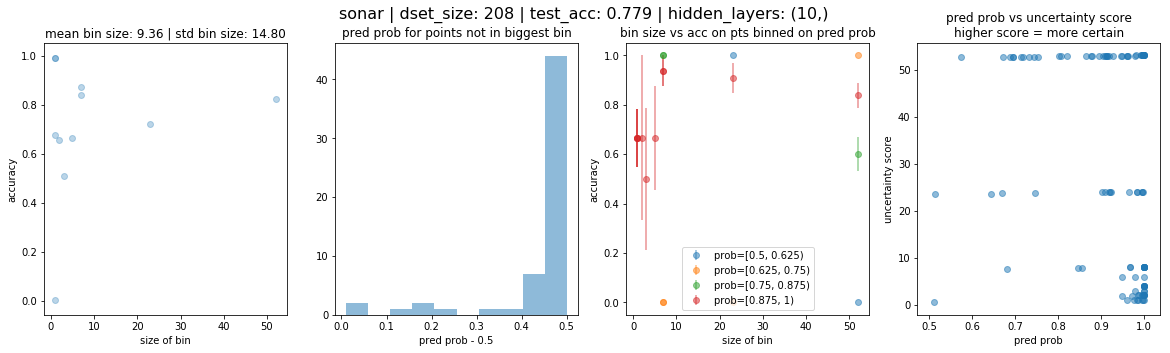

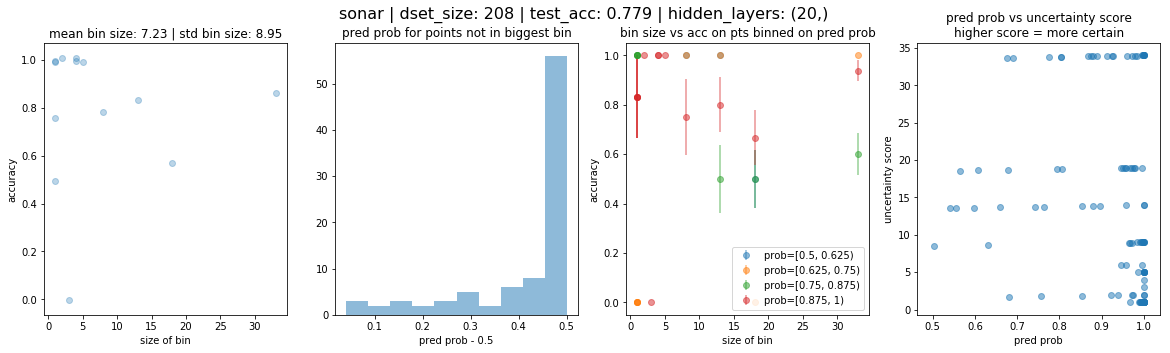

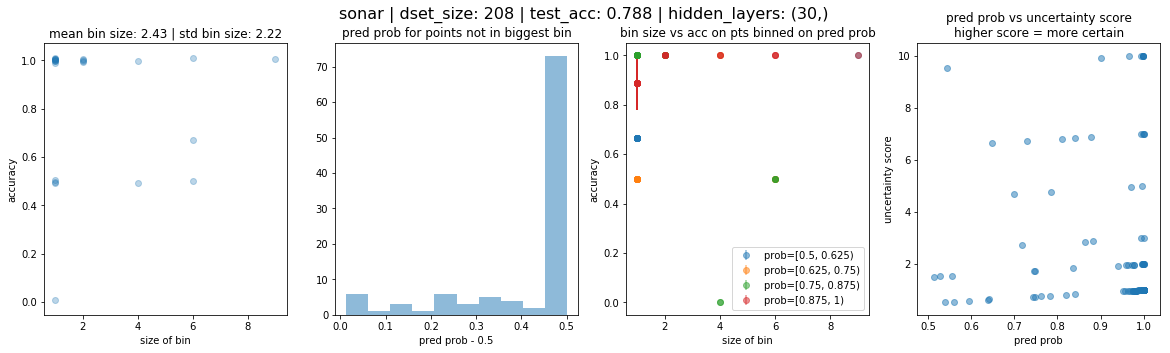

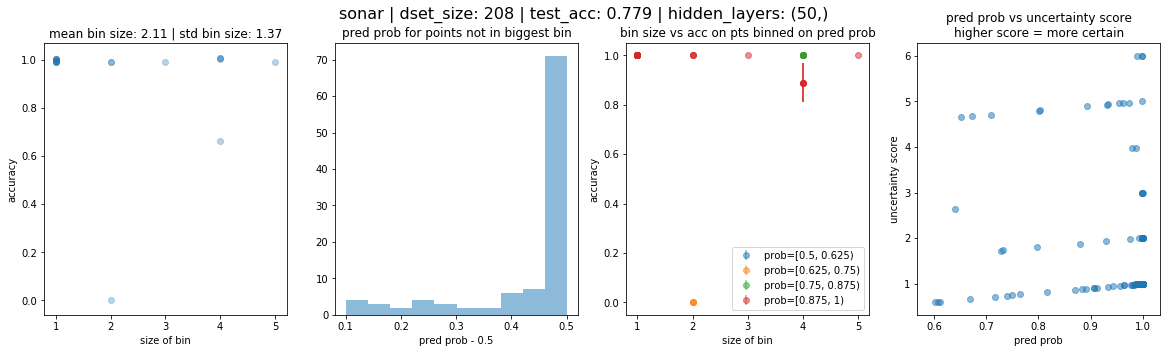

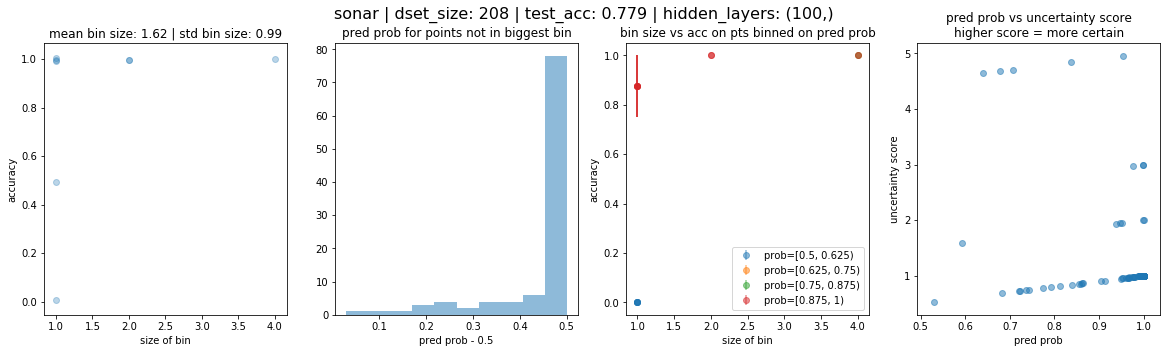

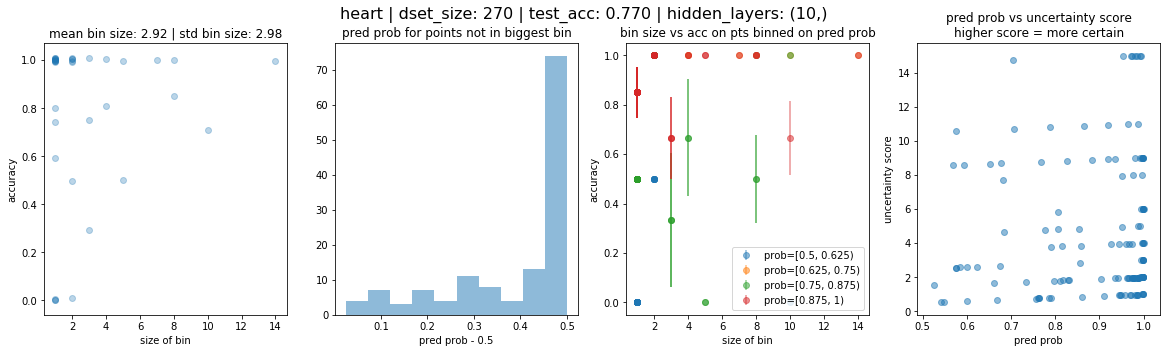

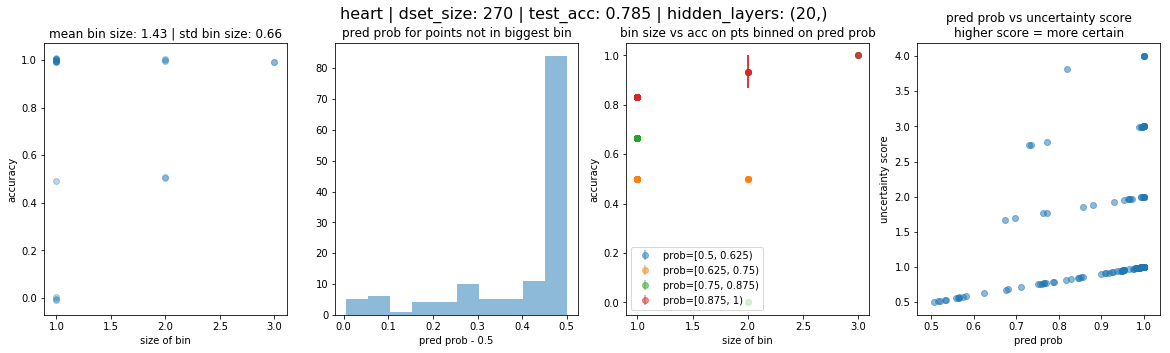

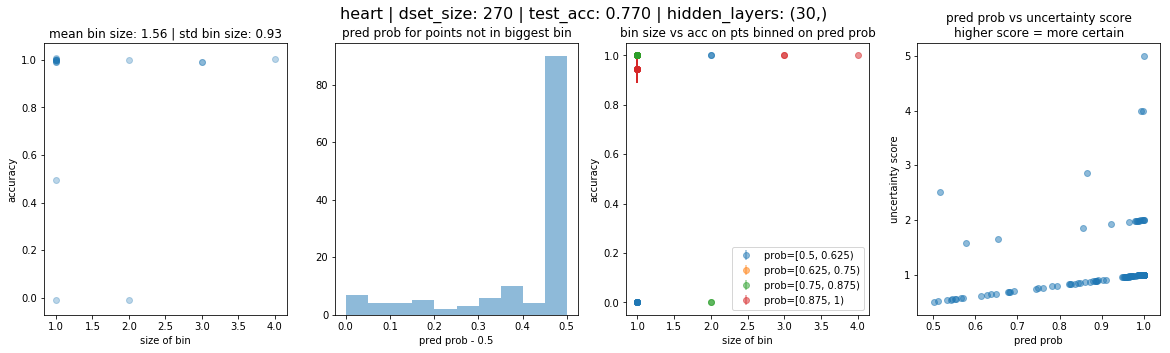

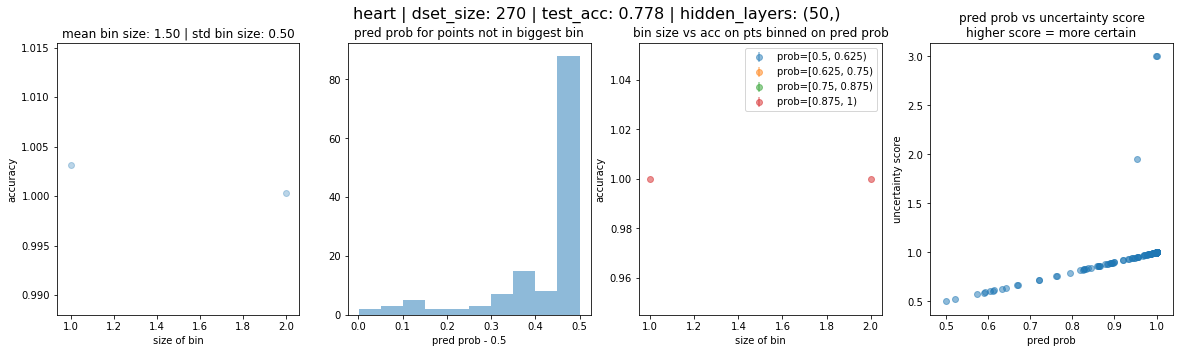

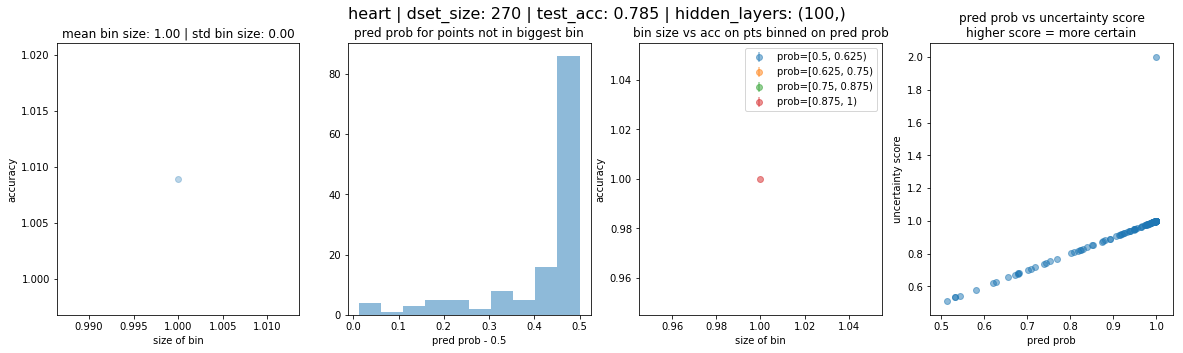

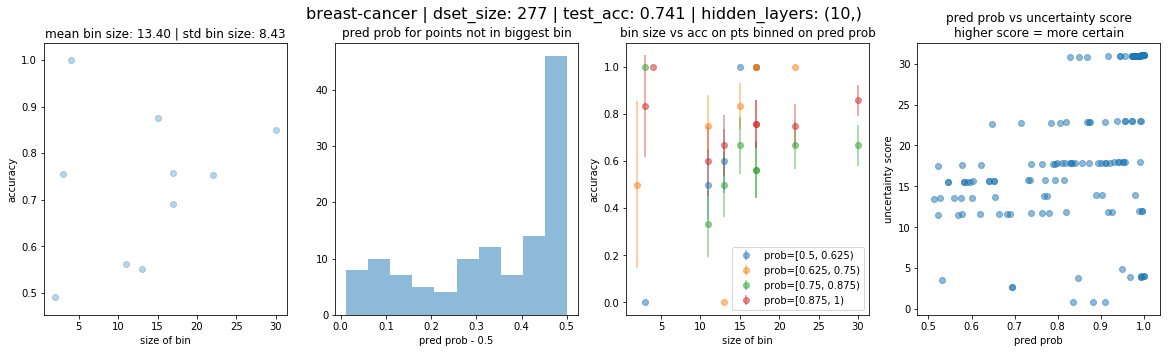

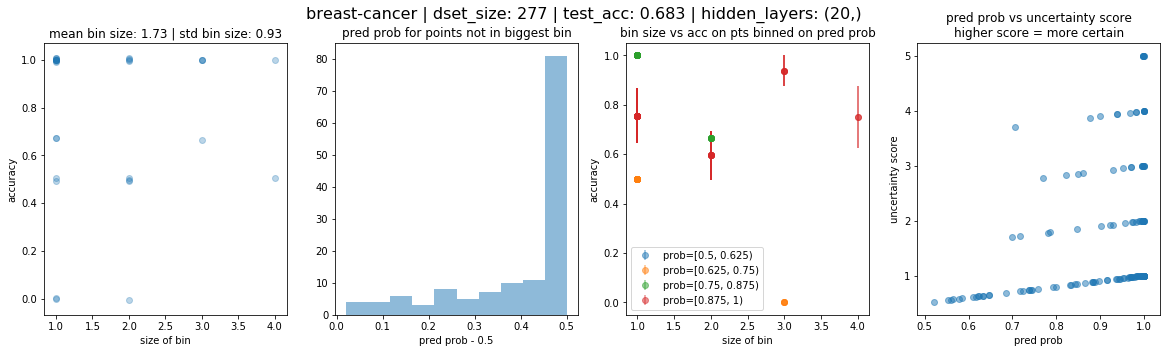

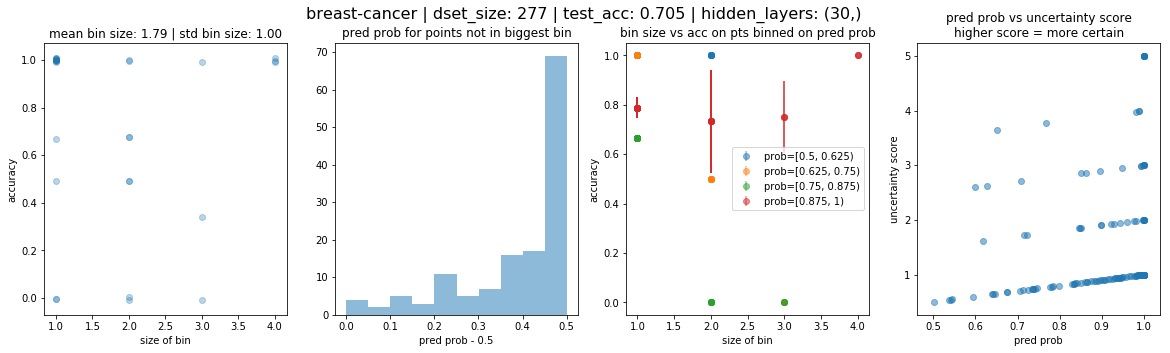

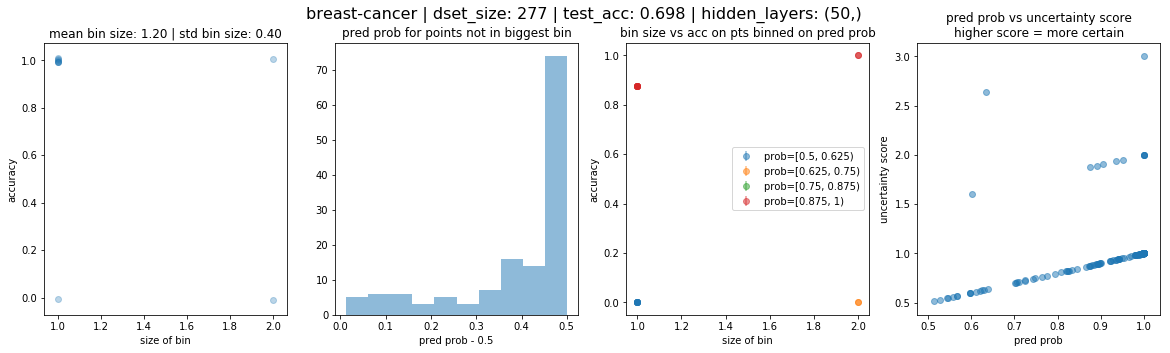

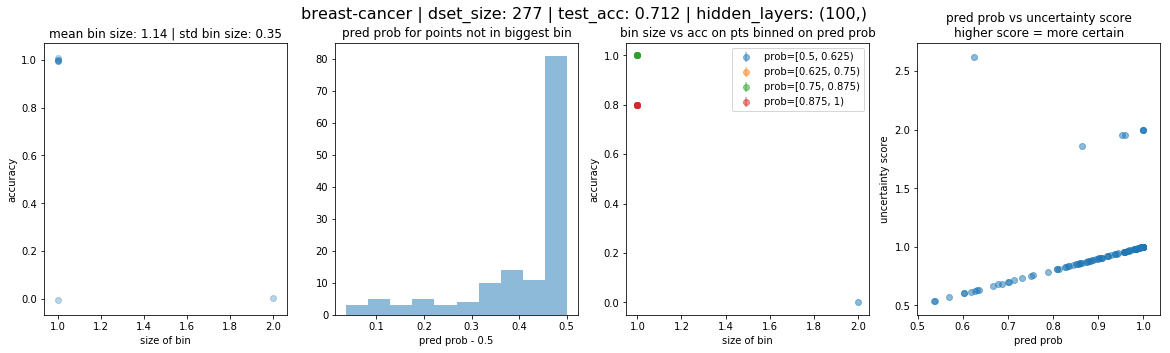

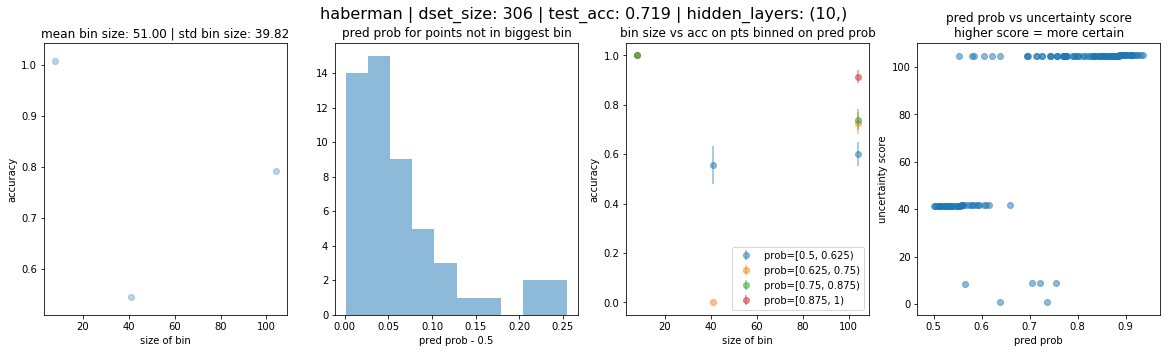

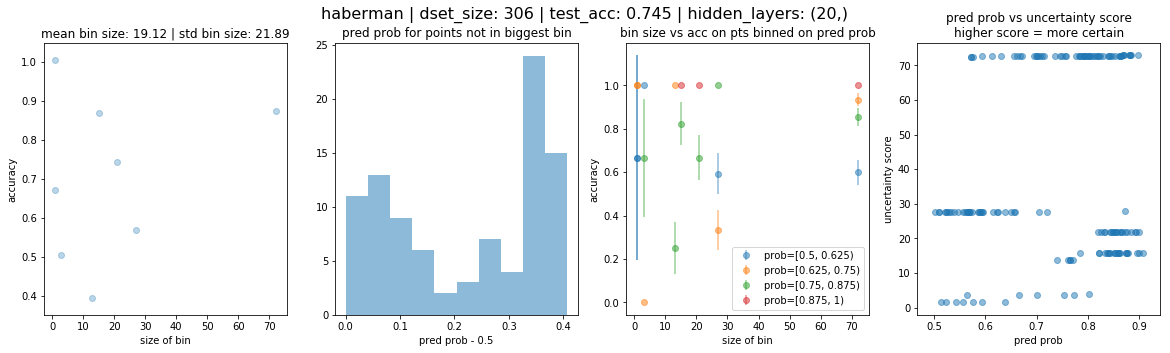

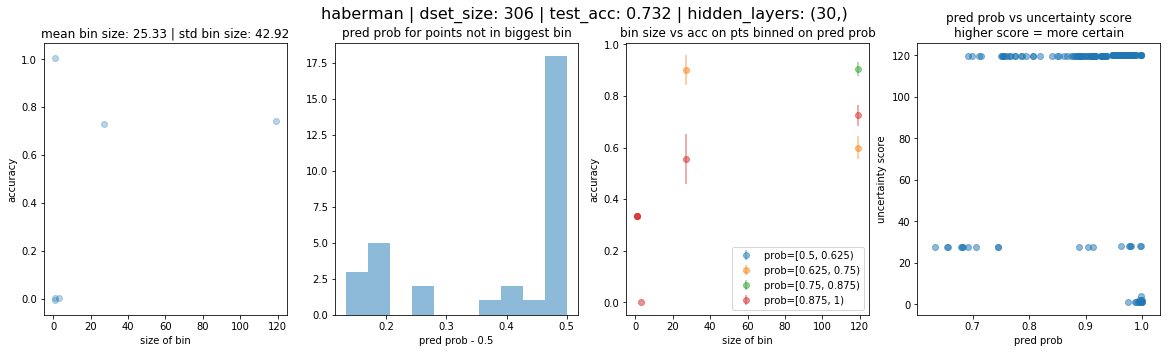

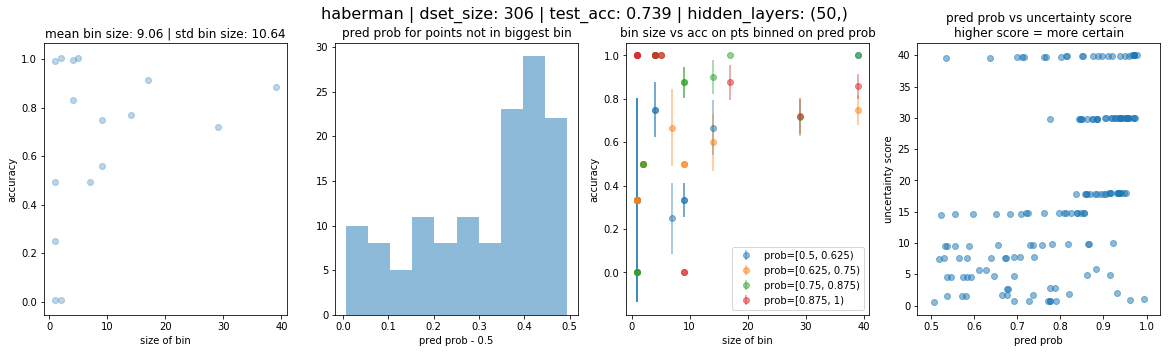

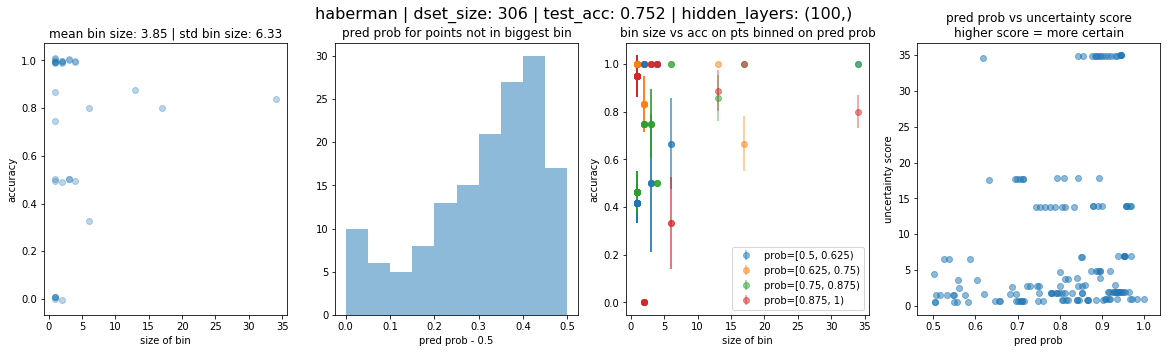

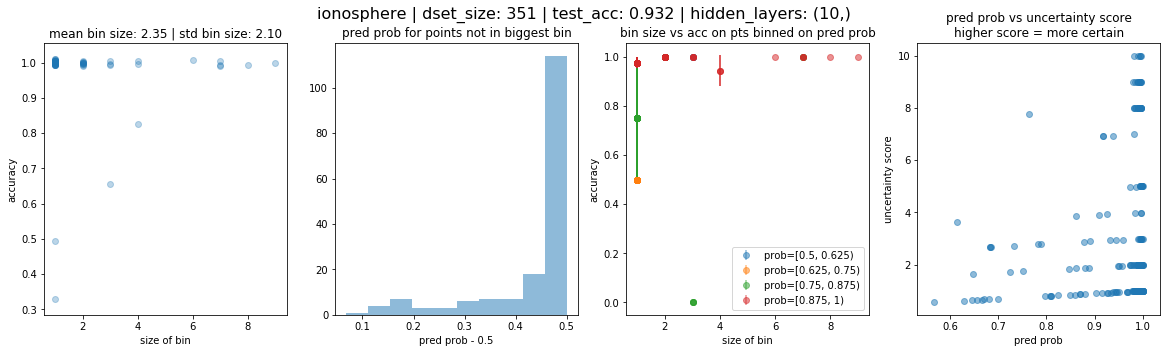

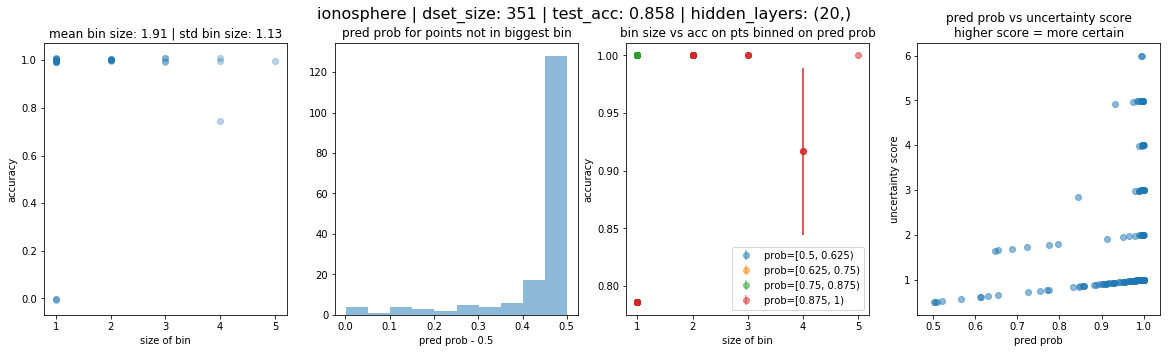

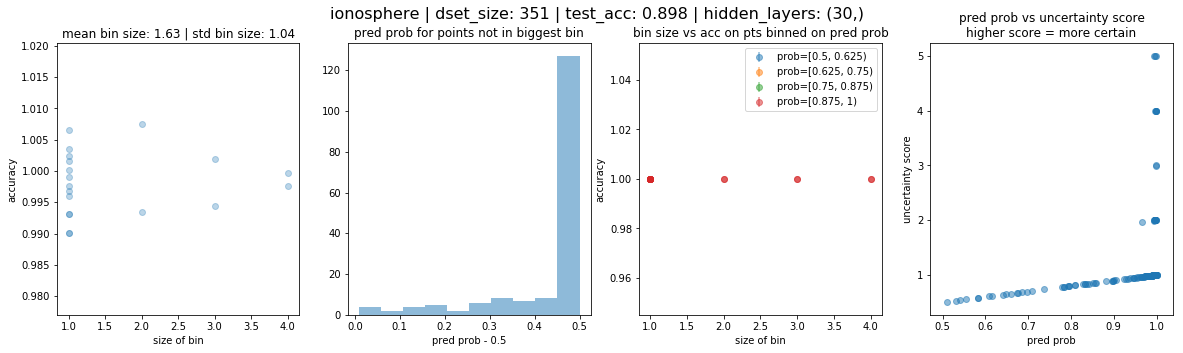

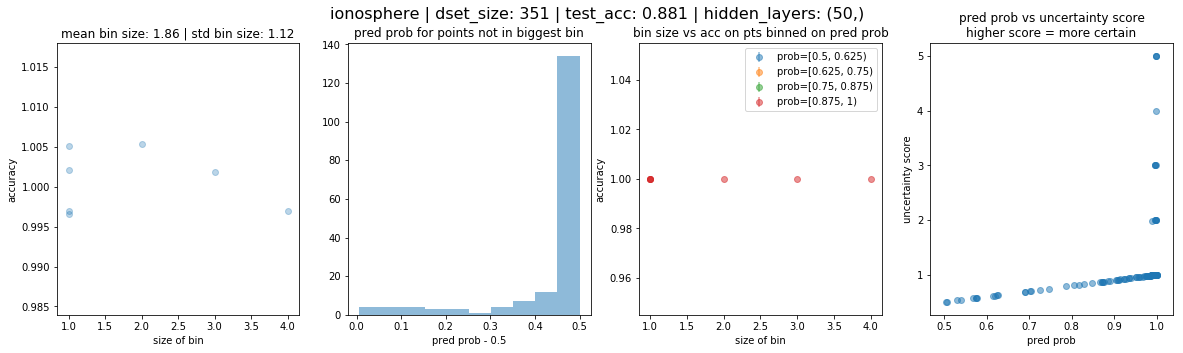

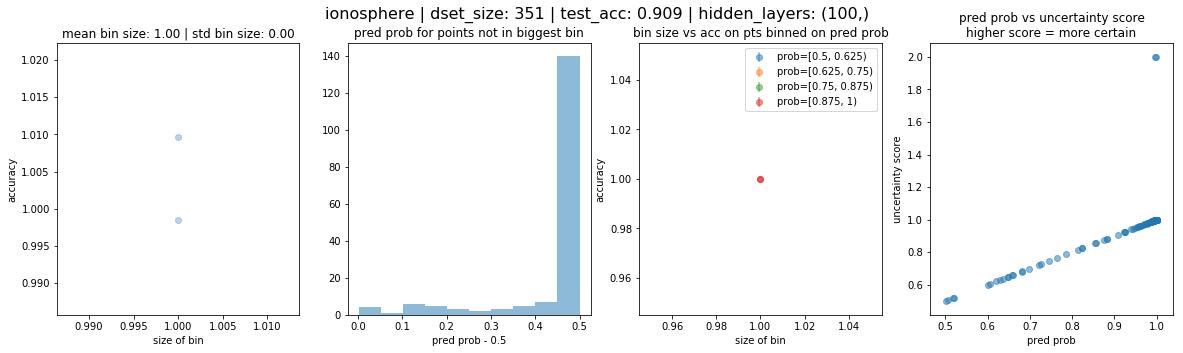

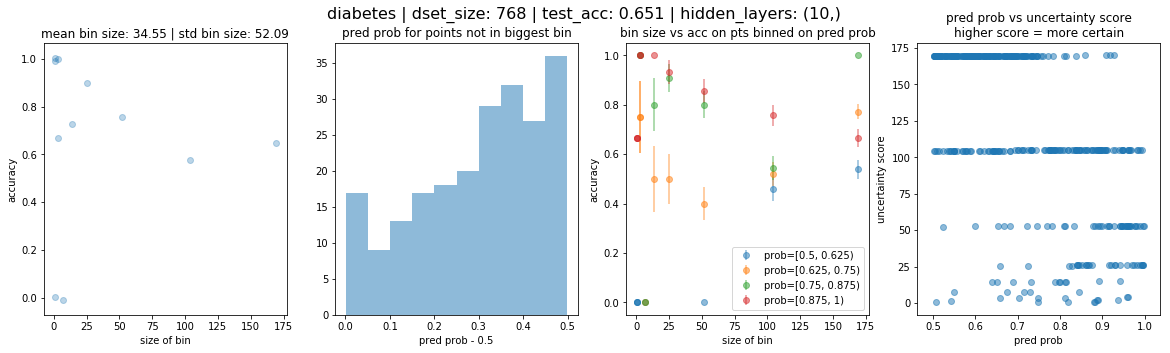

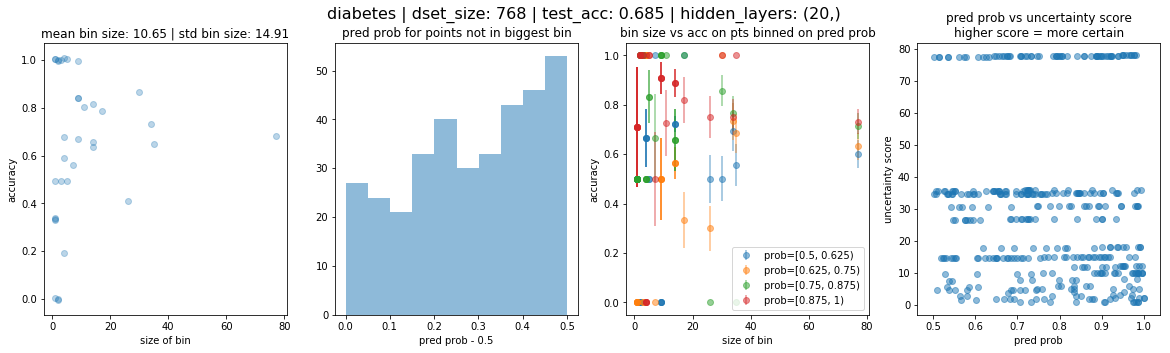

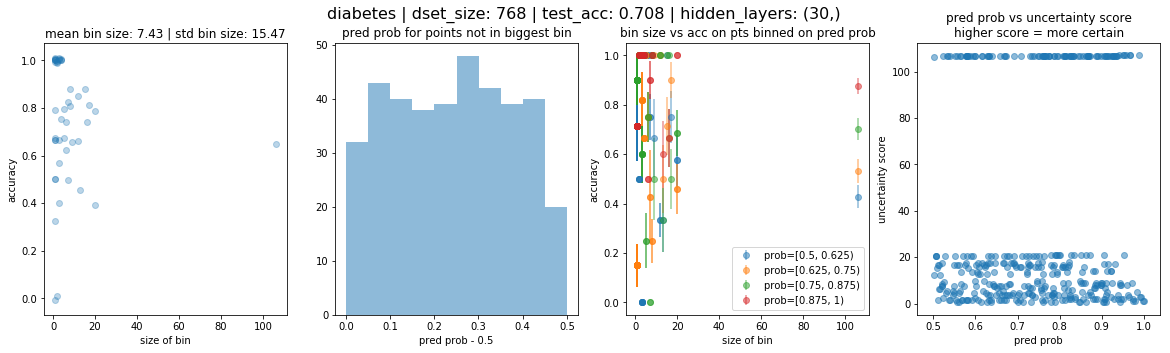

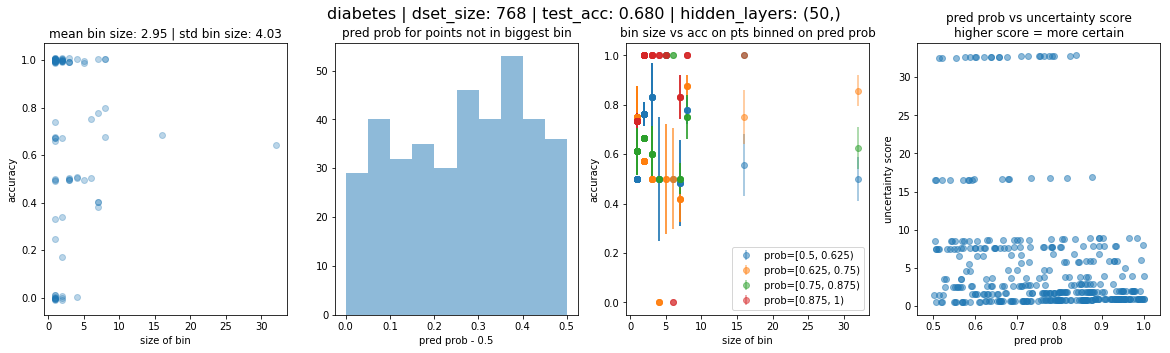

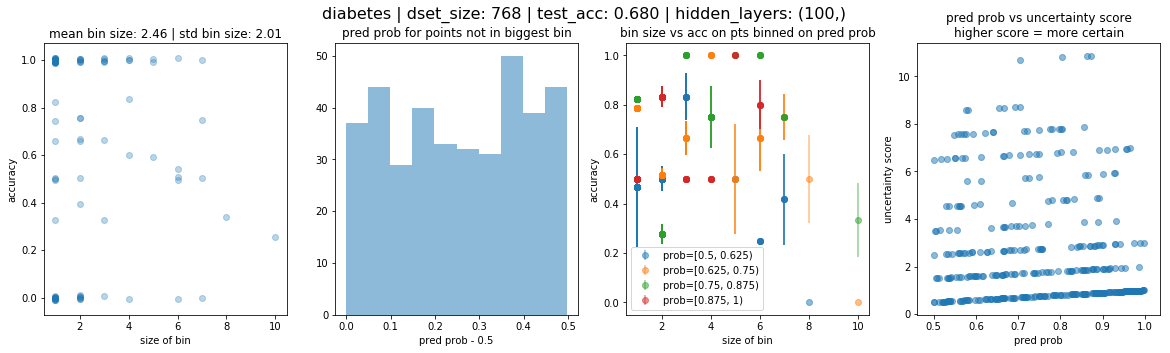

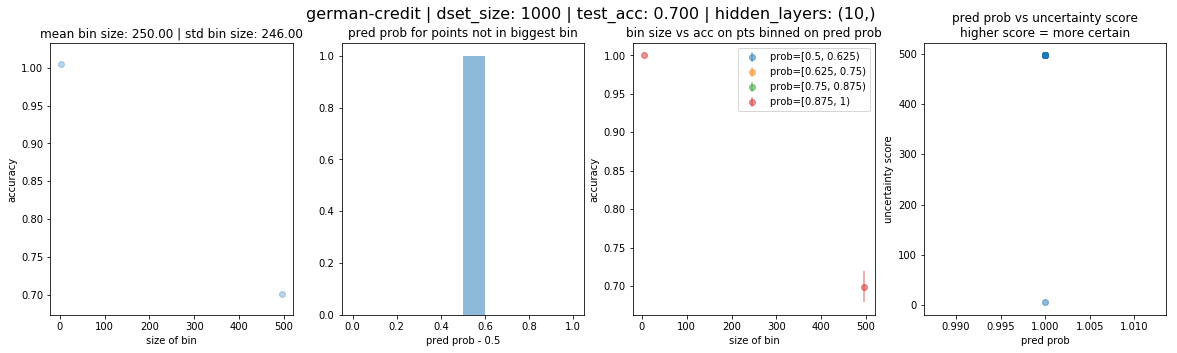

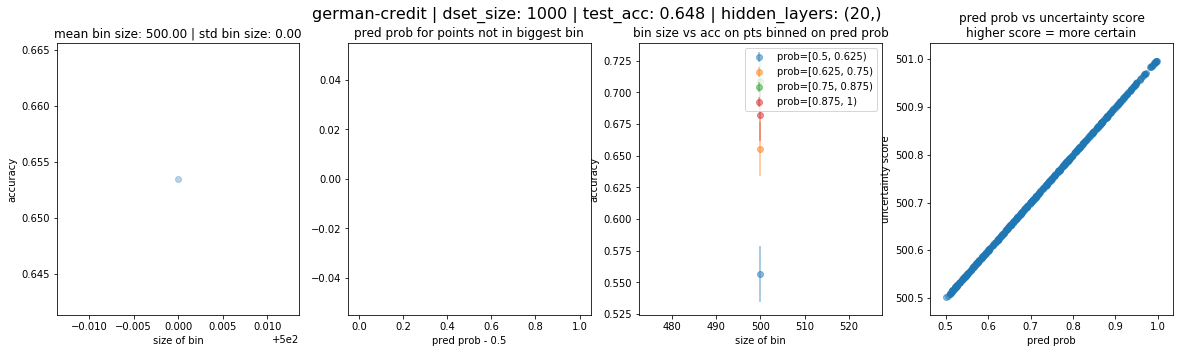

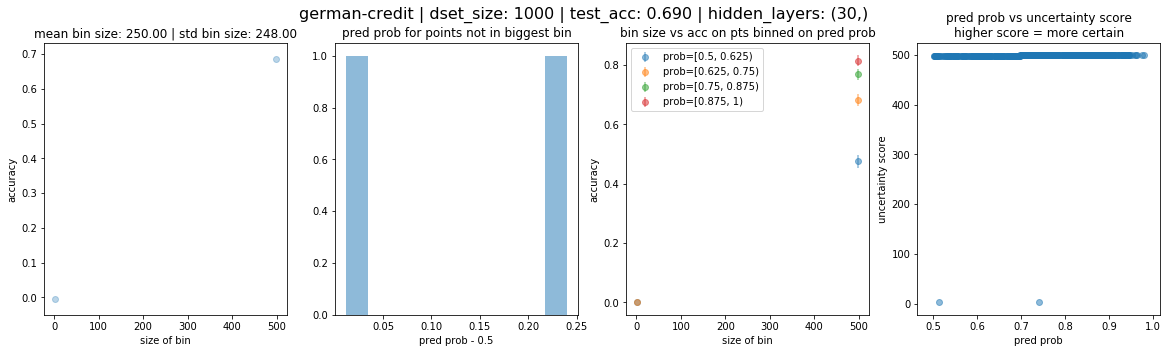

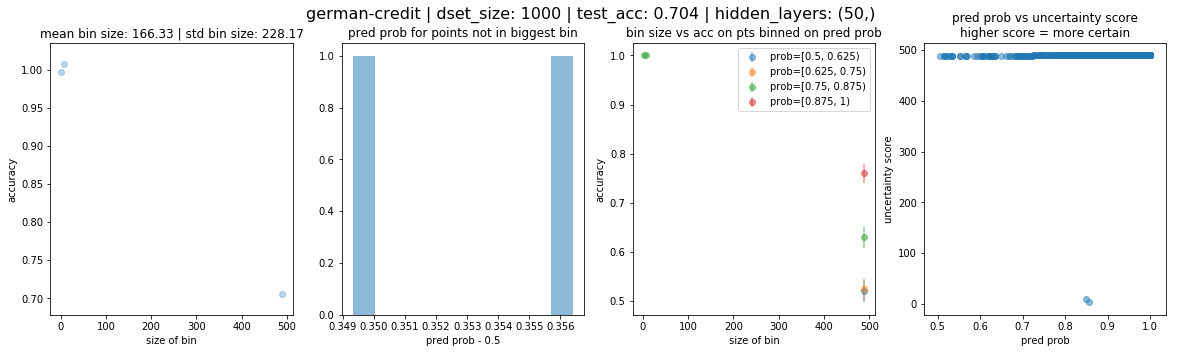

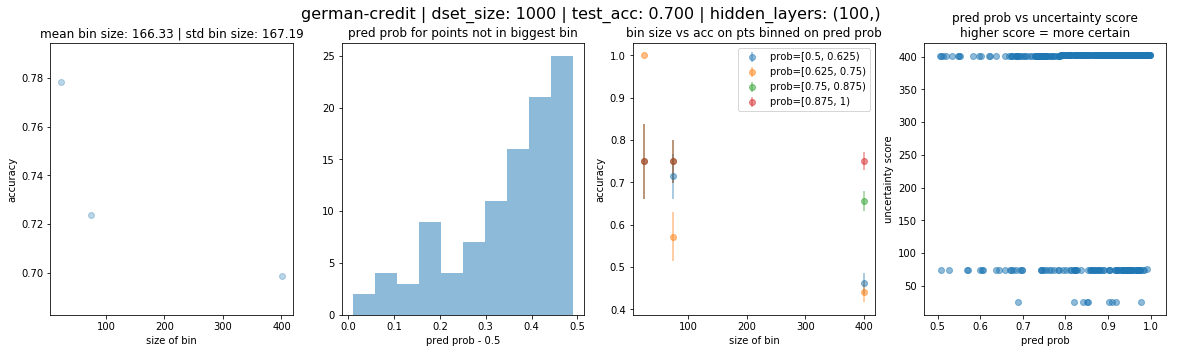

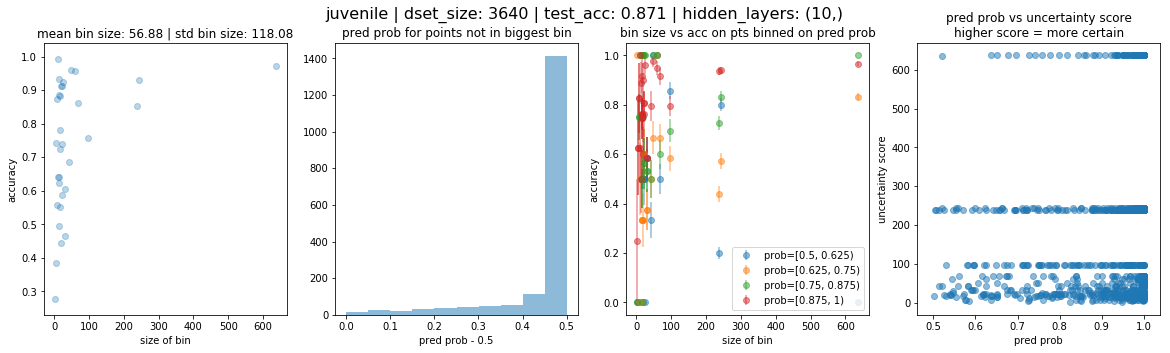

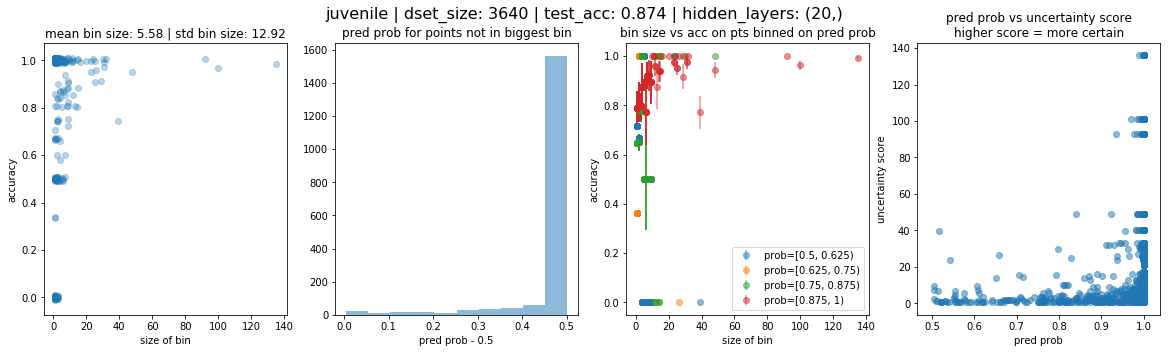

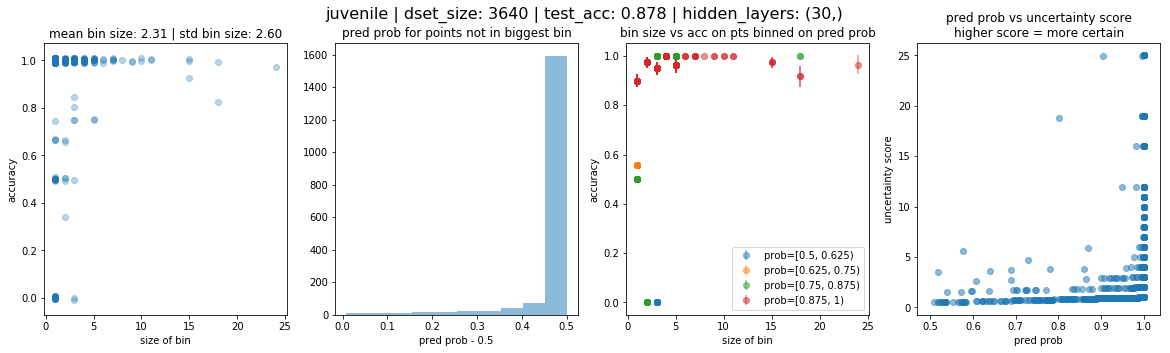

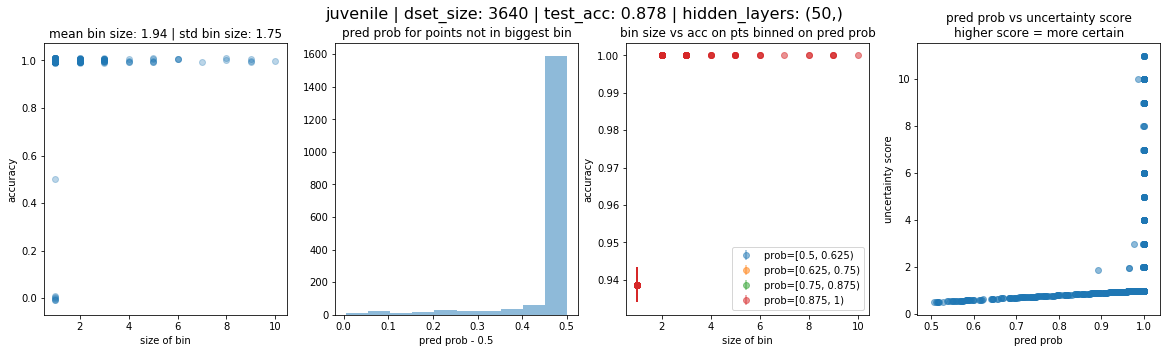

/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


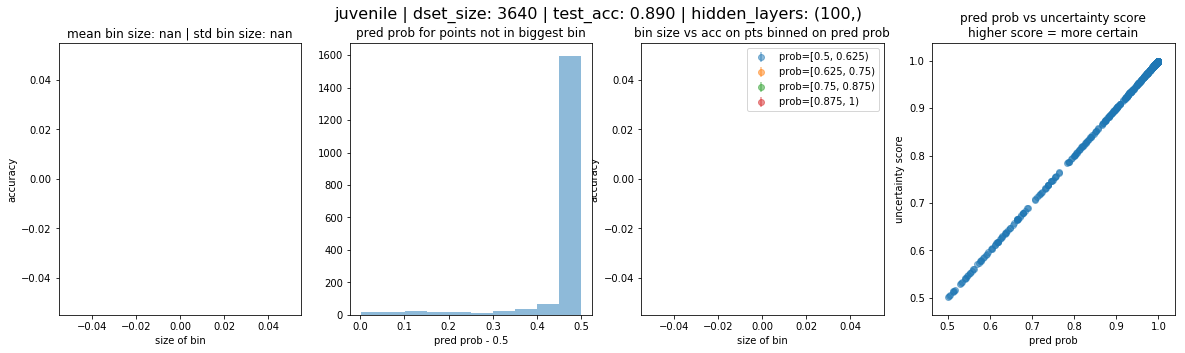

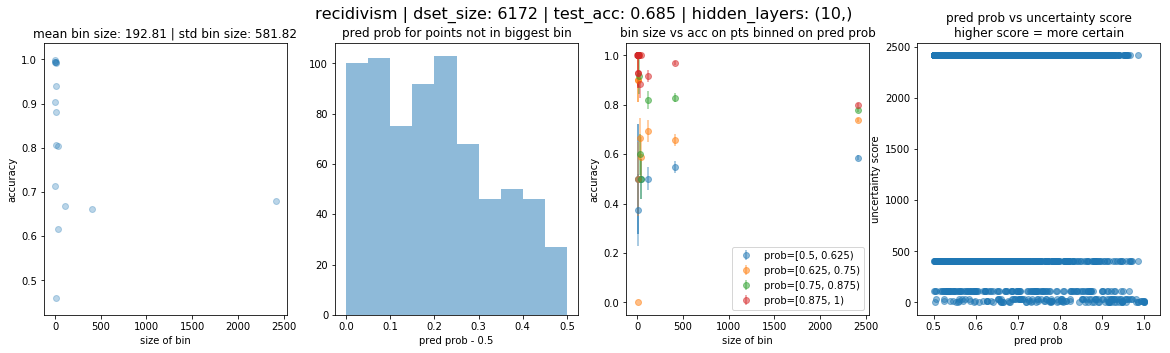

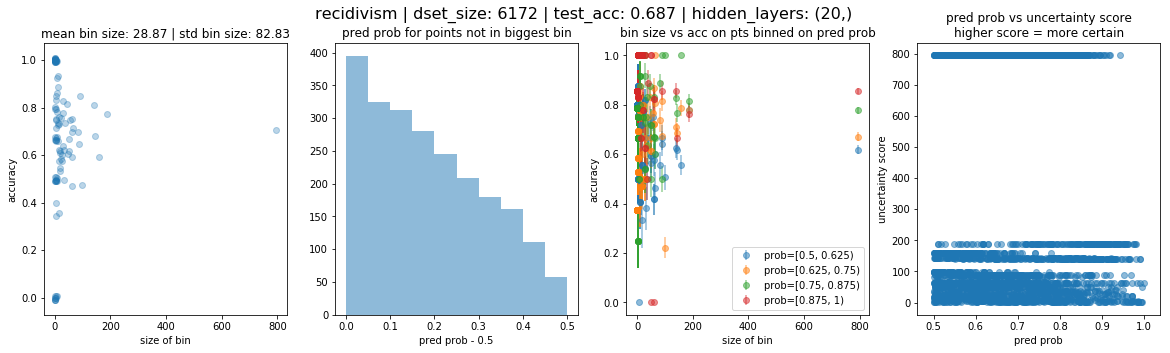

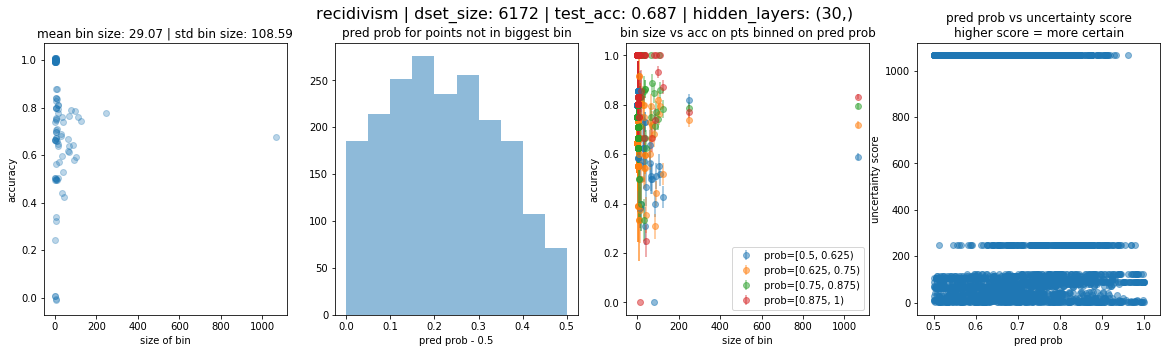

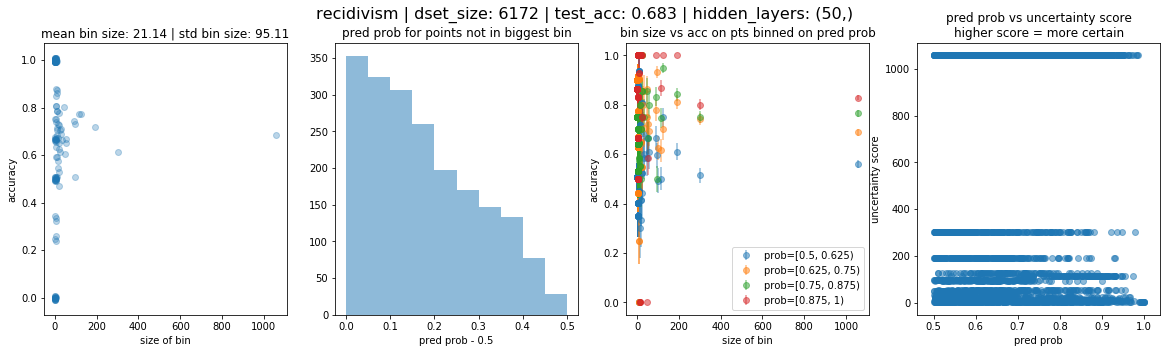

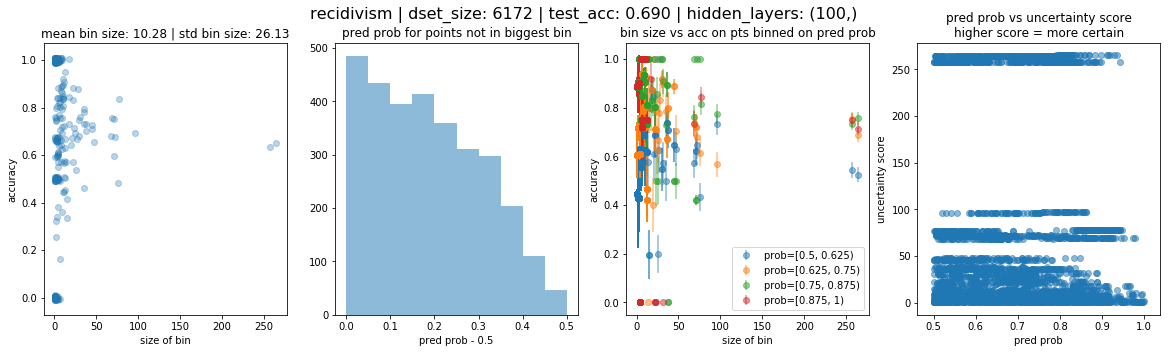

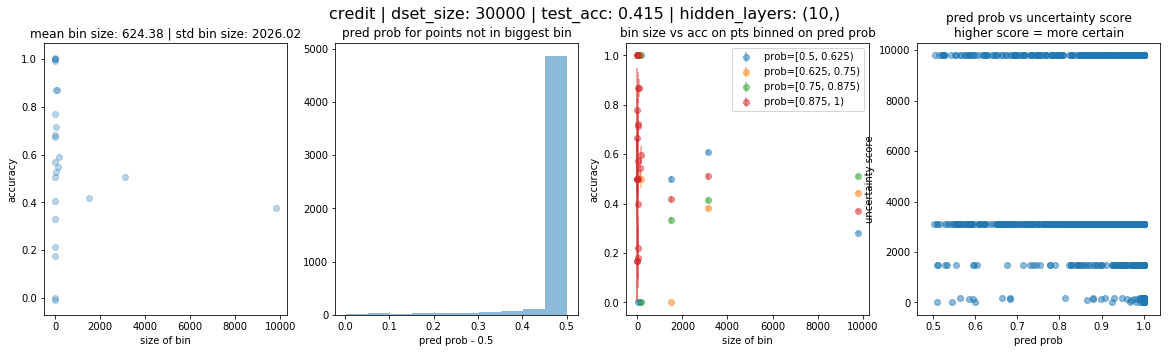

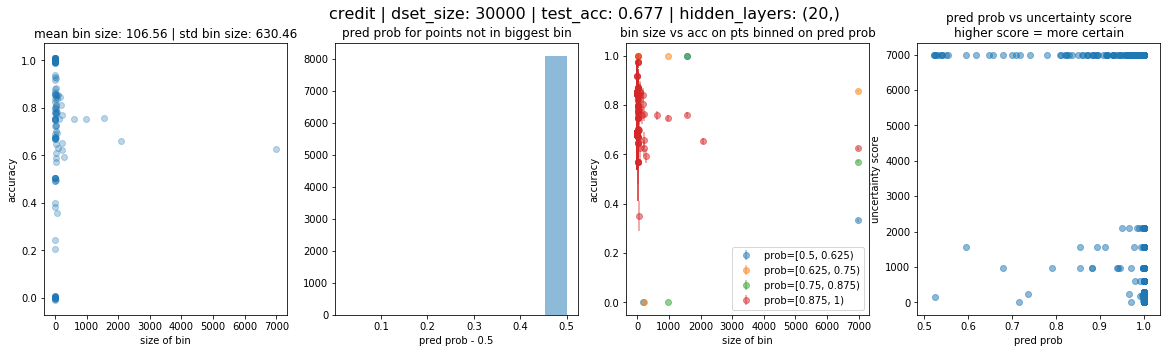

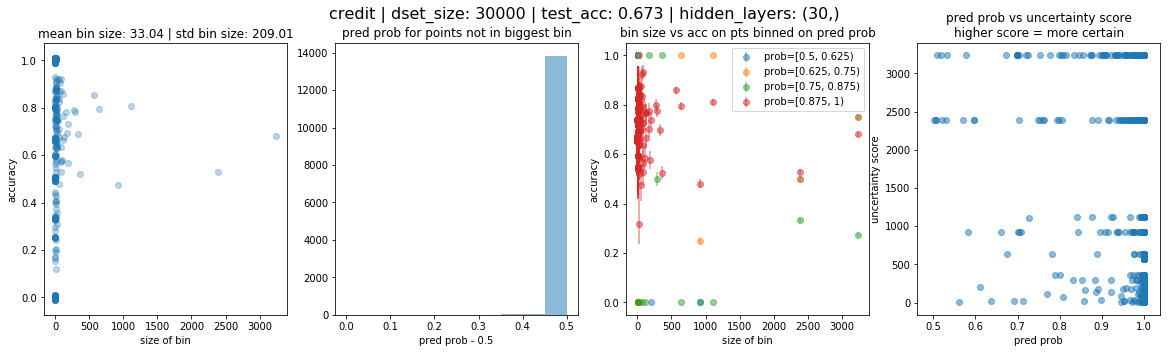

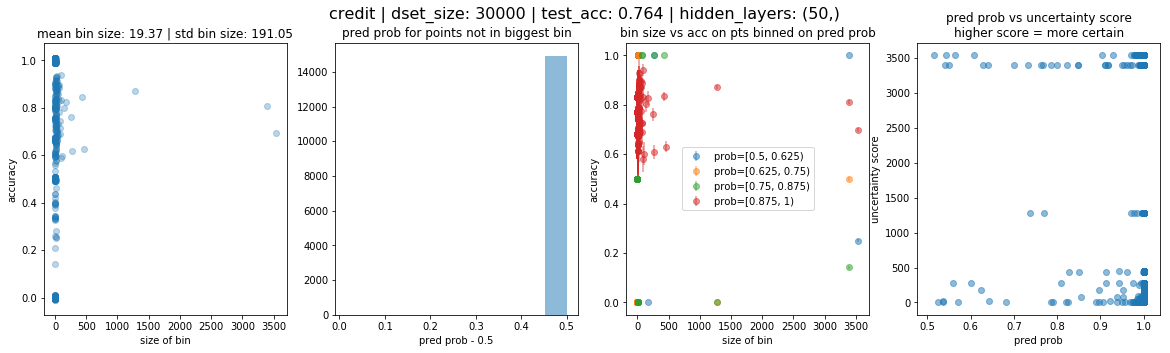

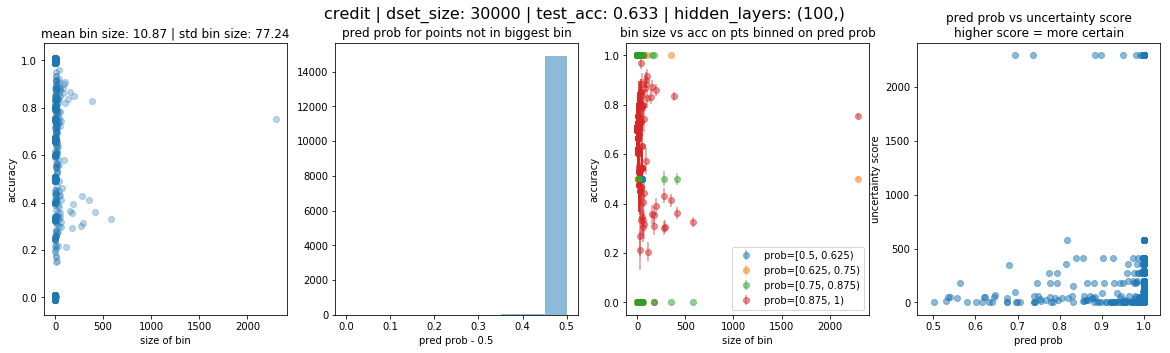

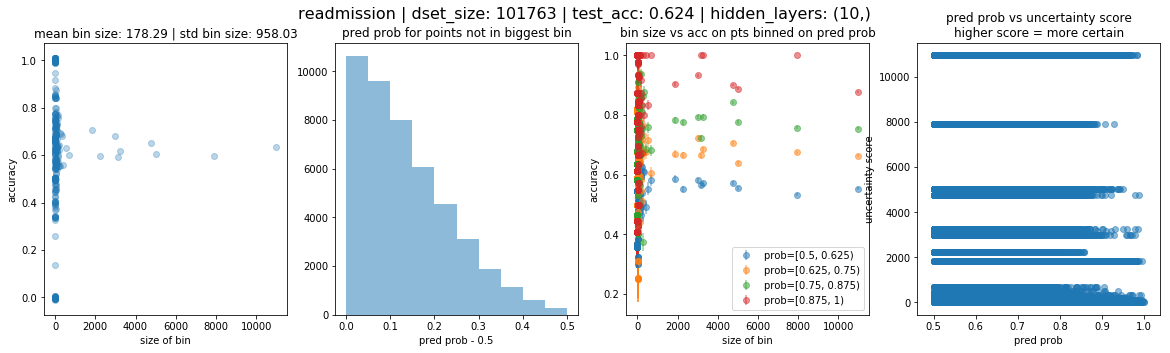

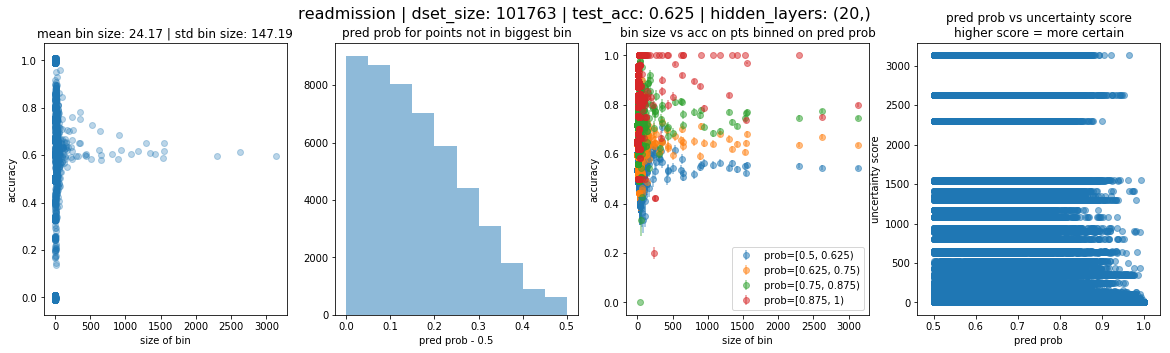

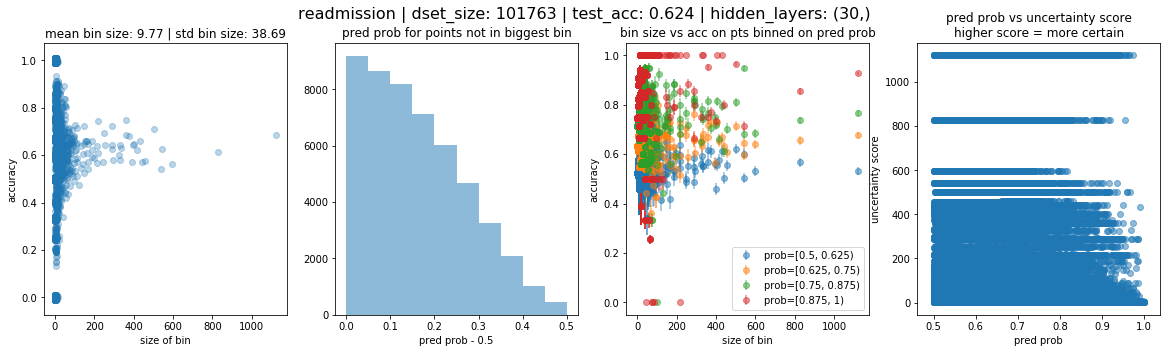

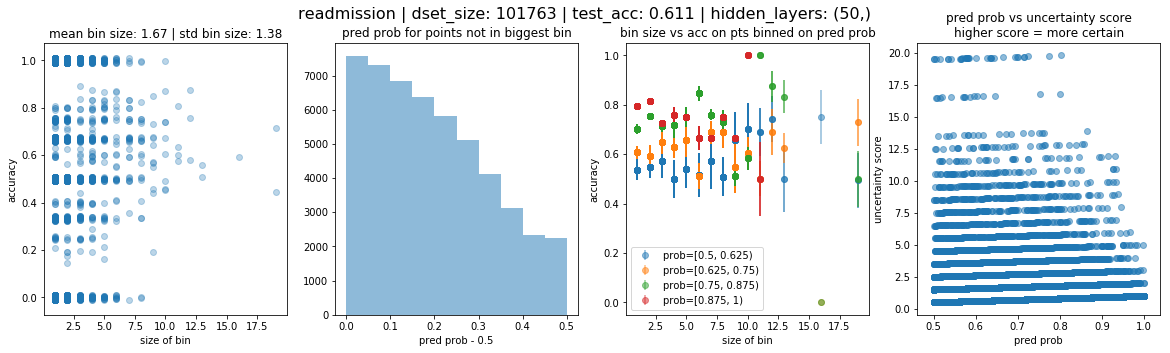

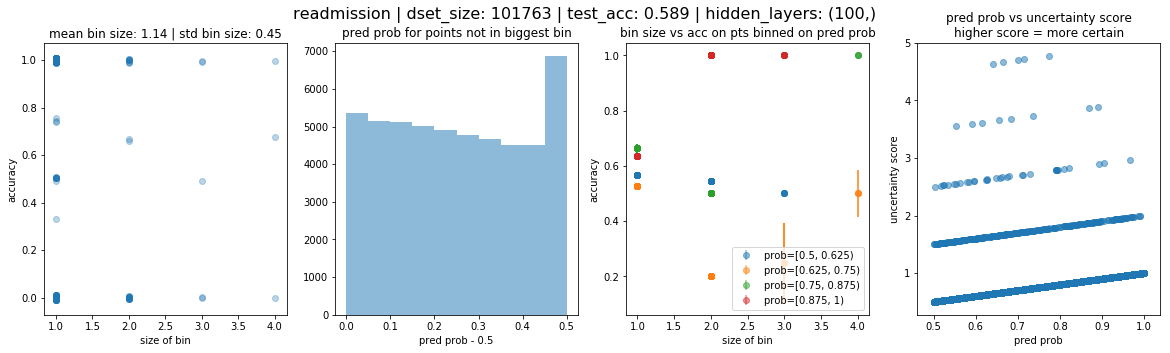

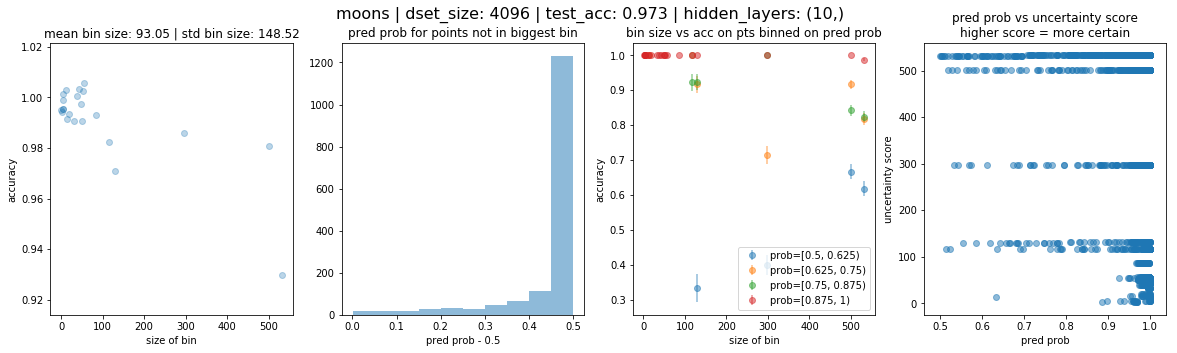

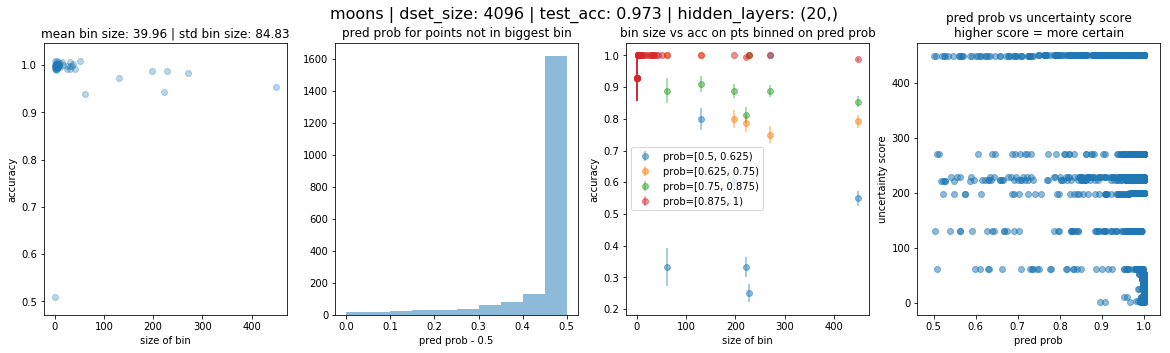

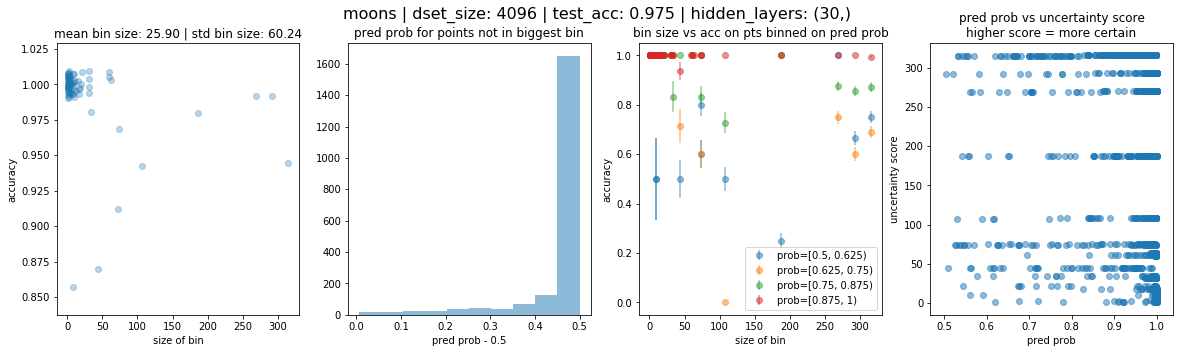

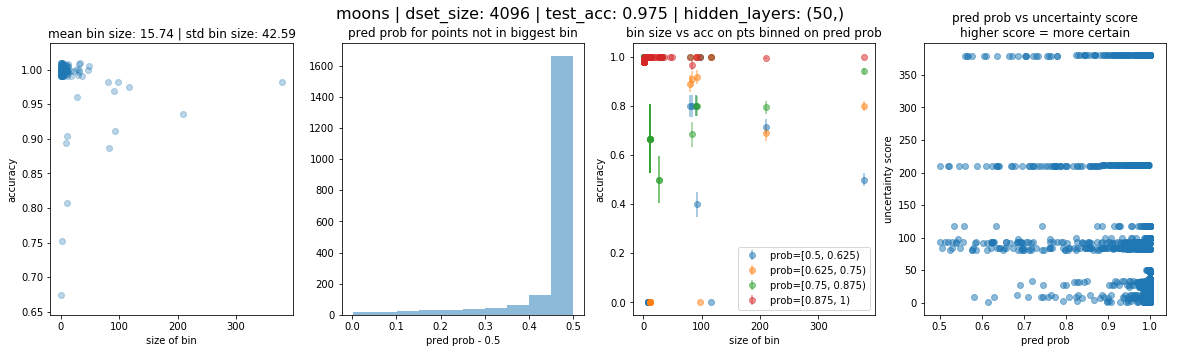

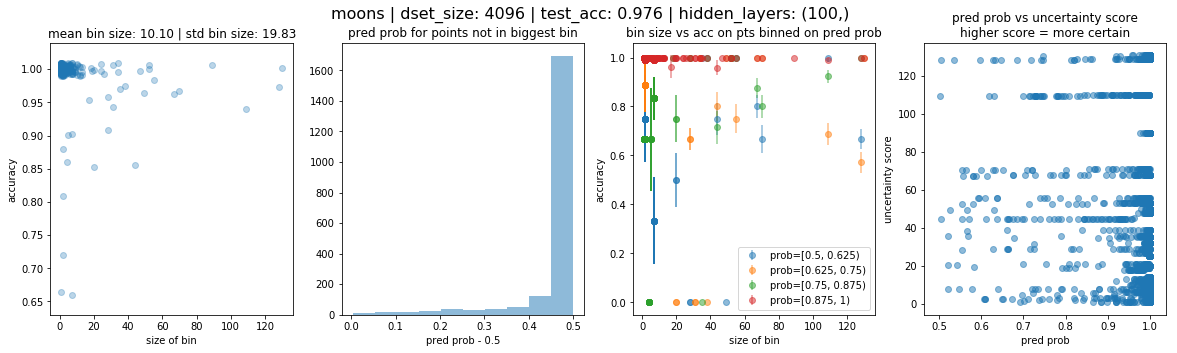

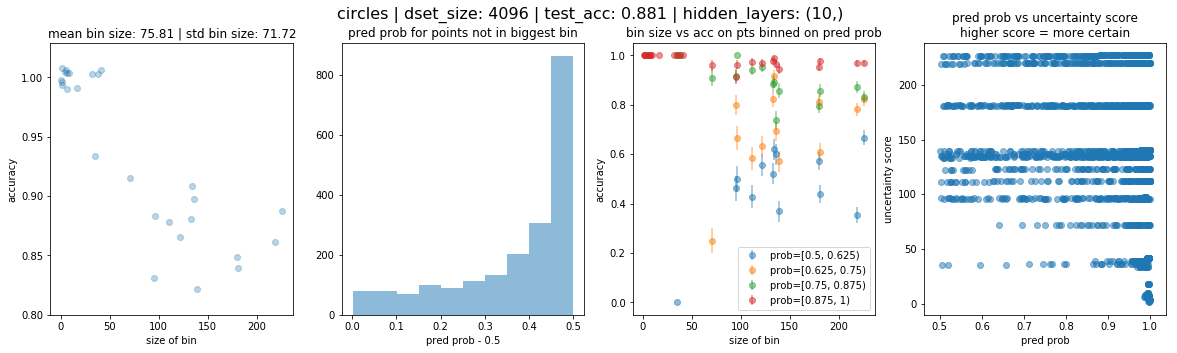

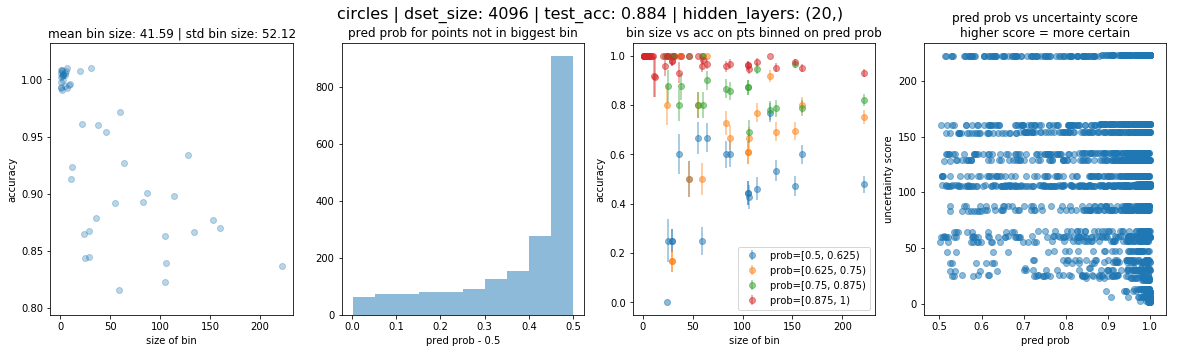

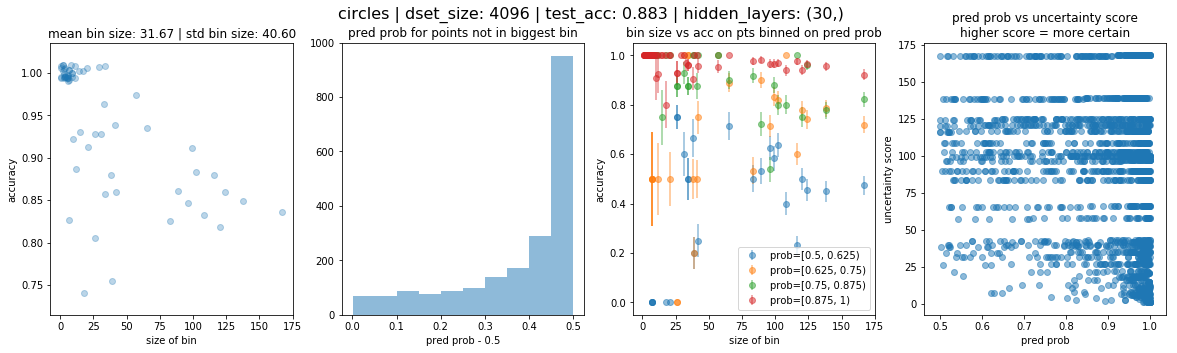

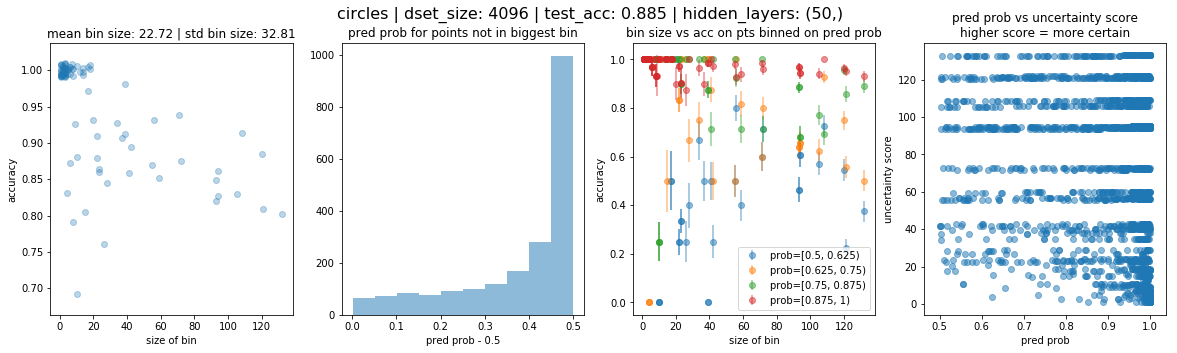

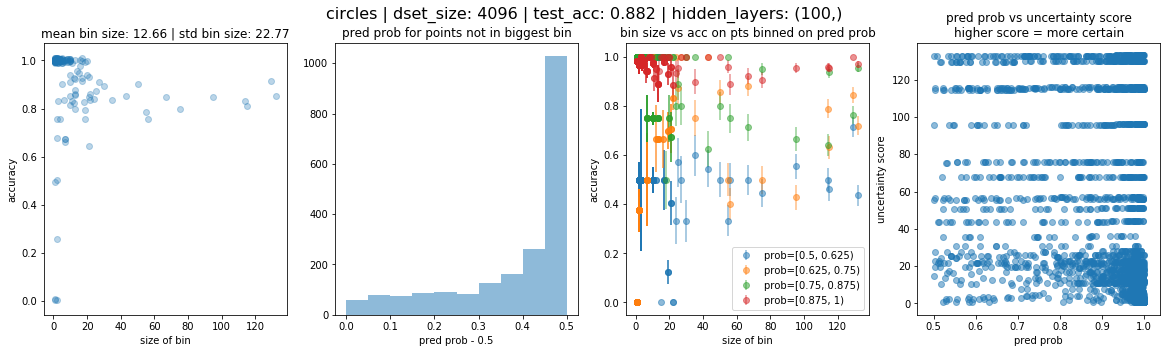

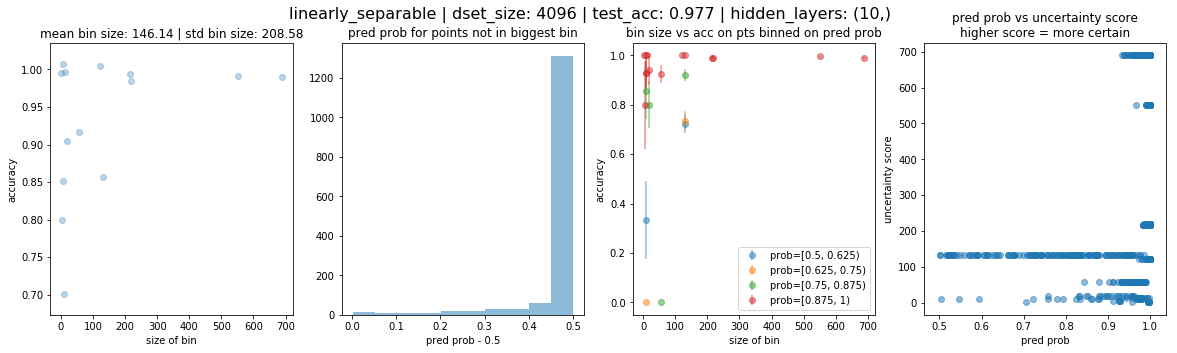

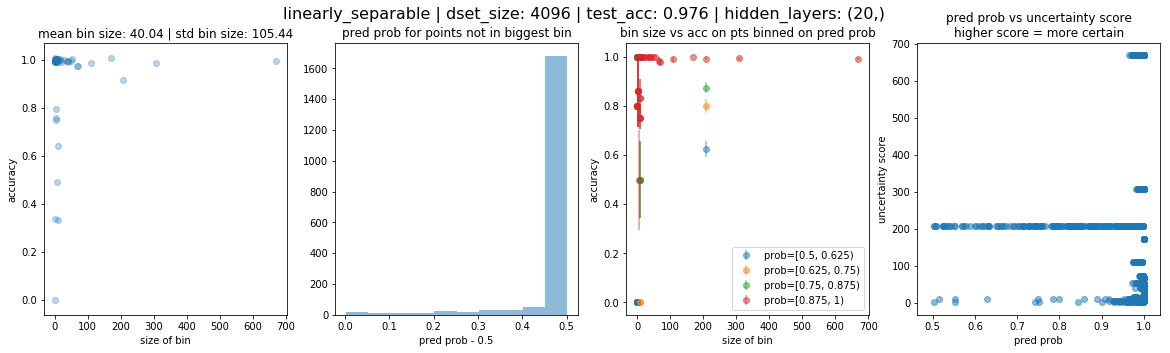

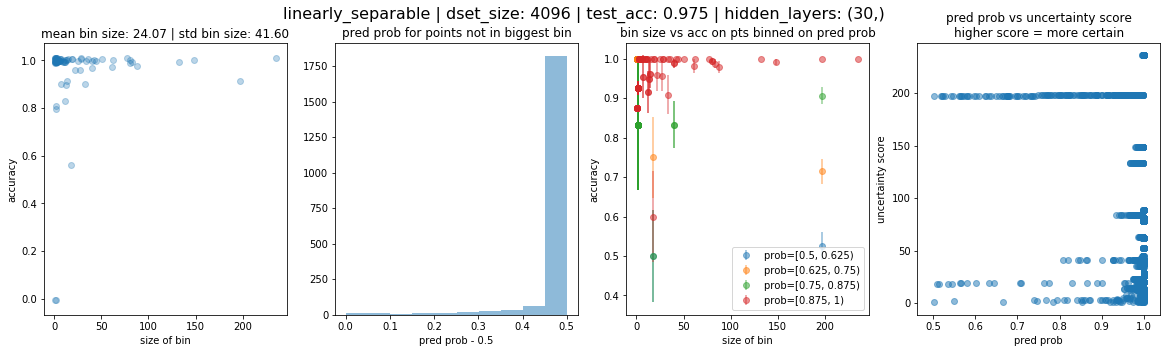

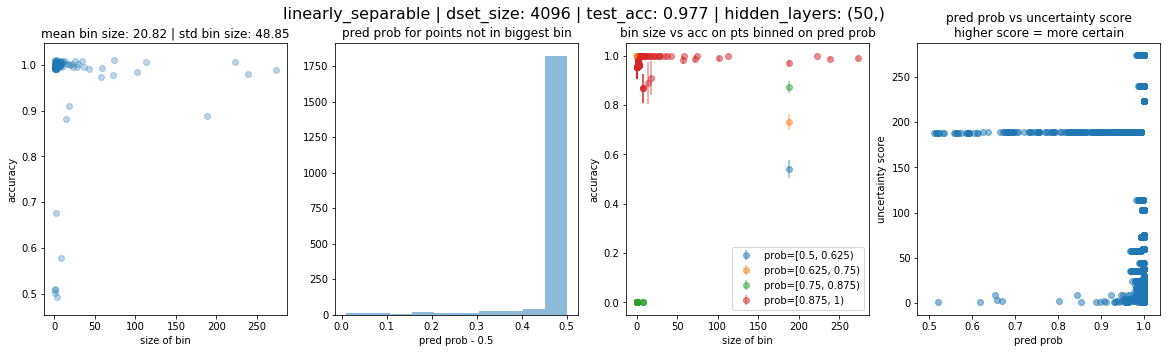

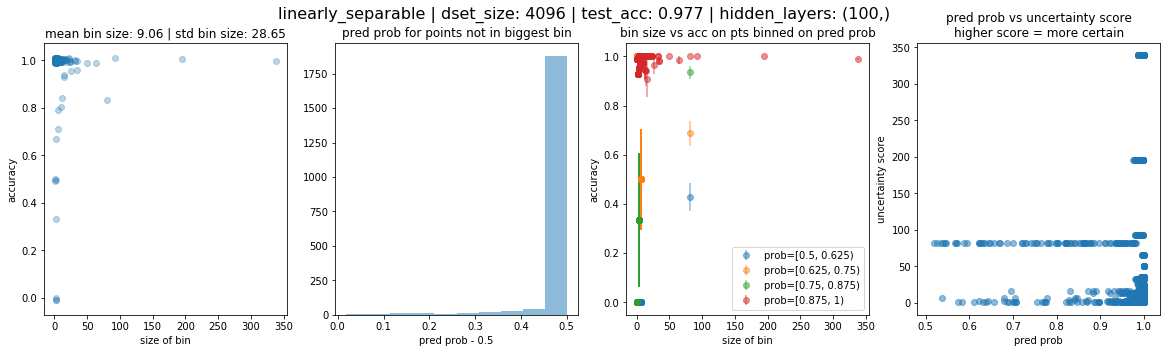

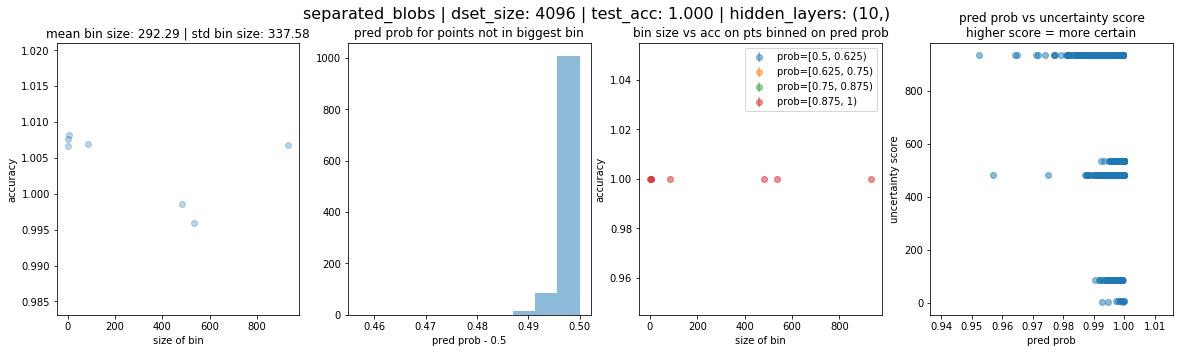

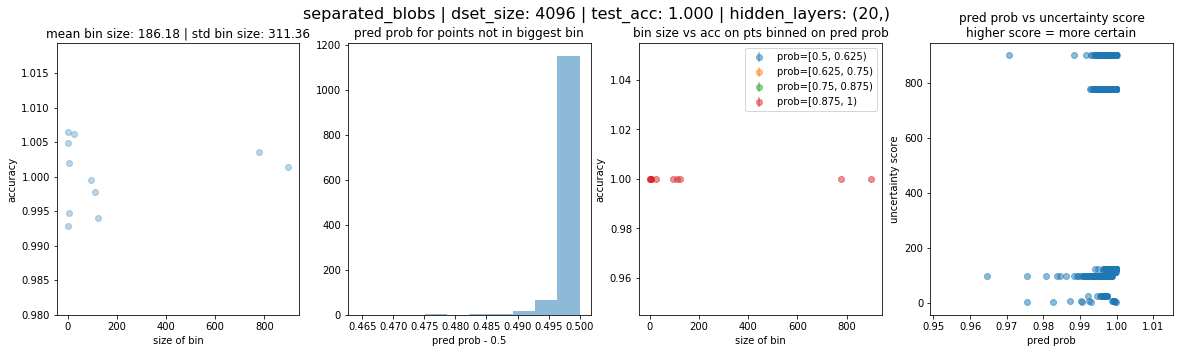

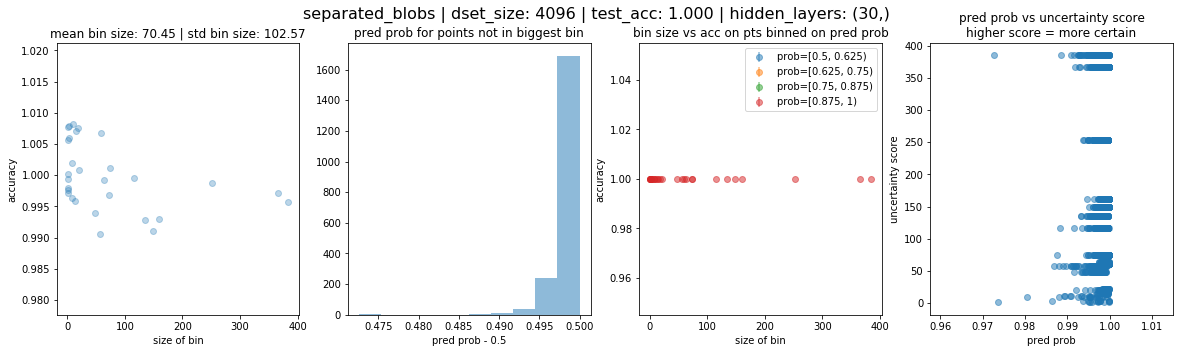

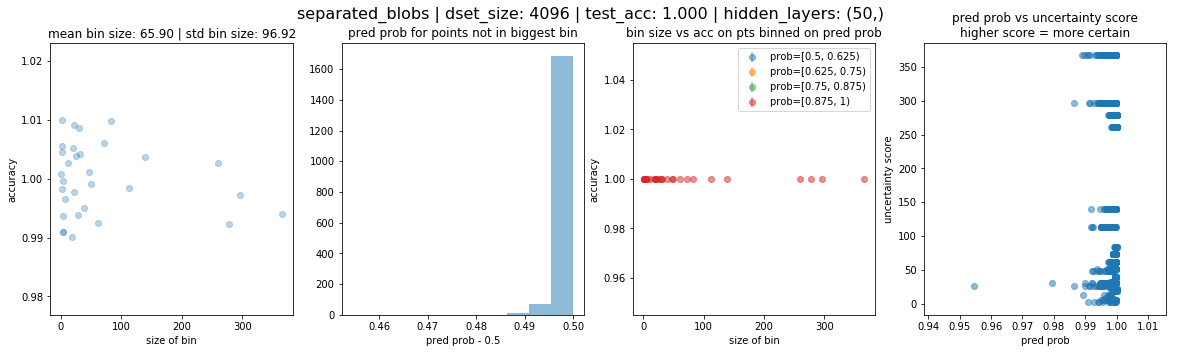

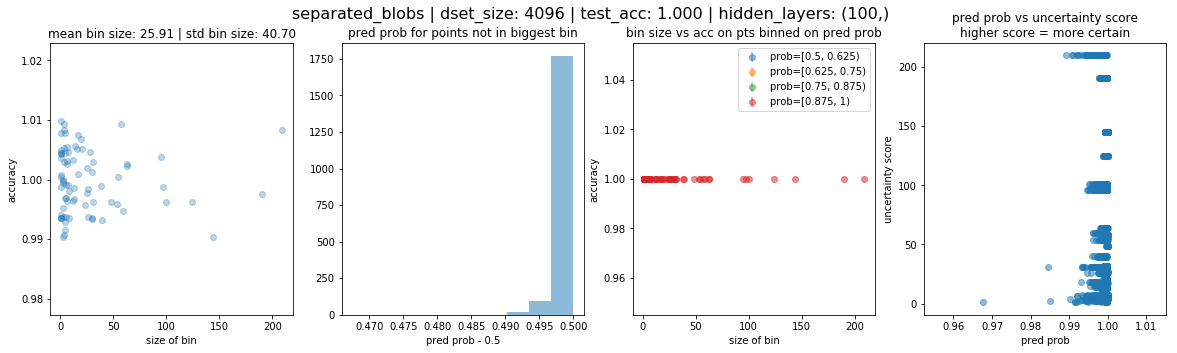

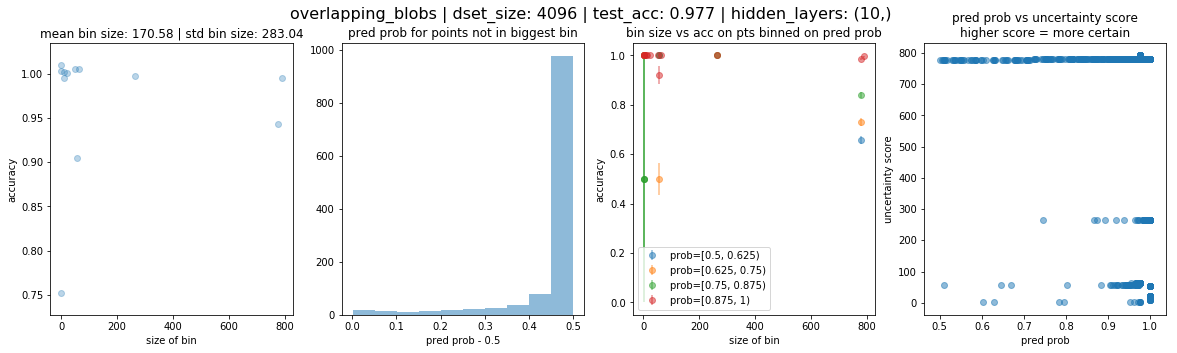

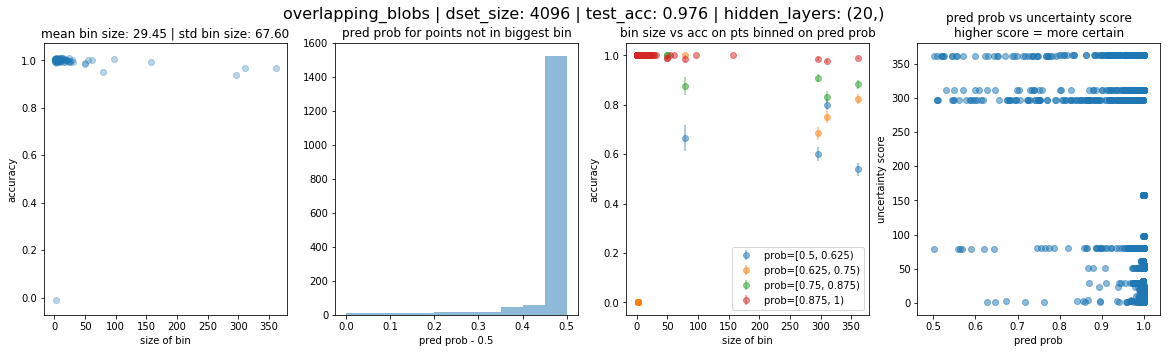

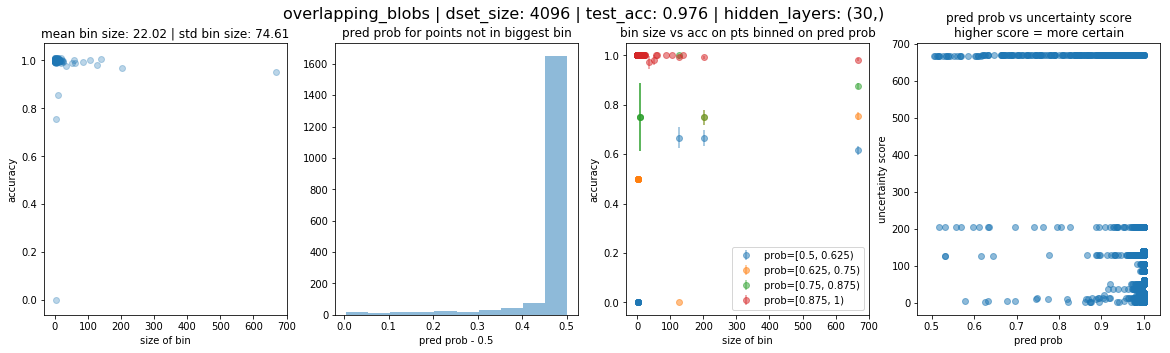

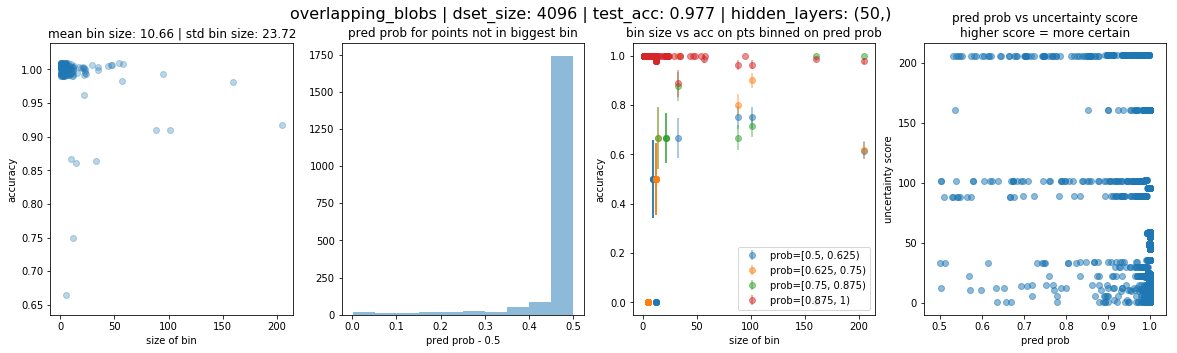

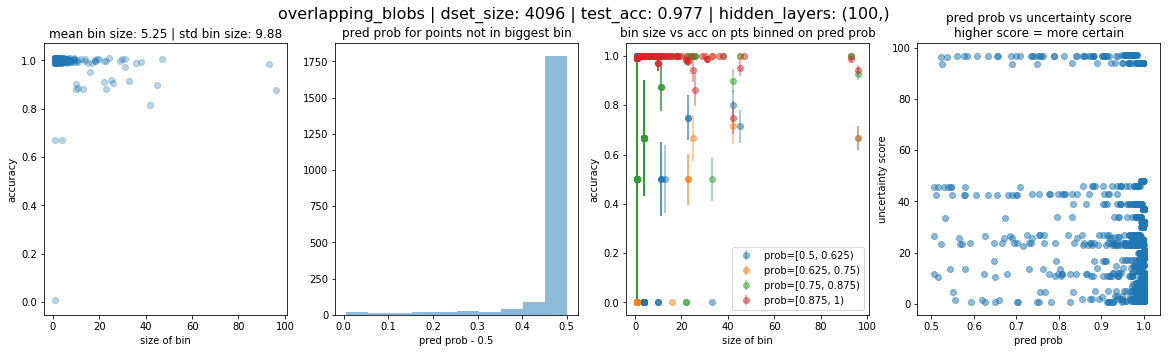

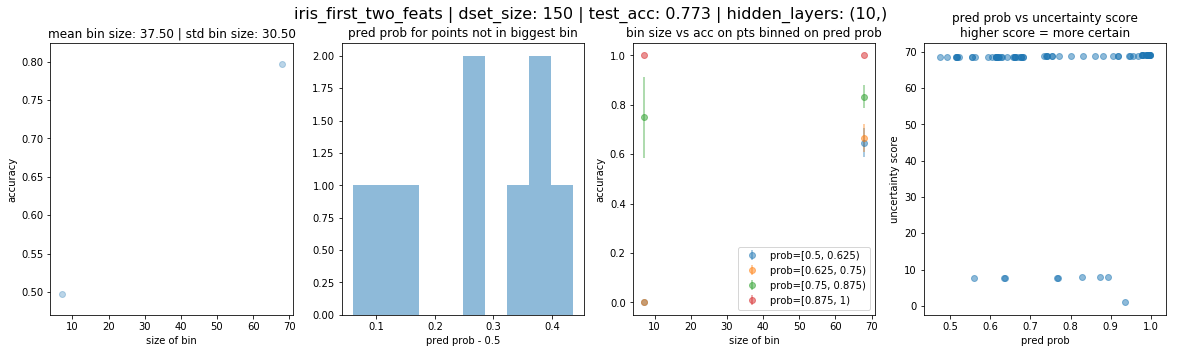

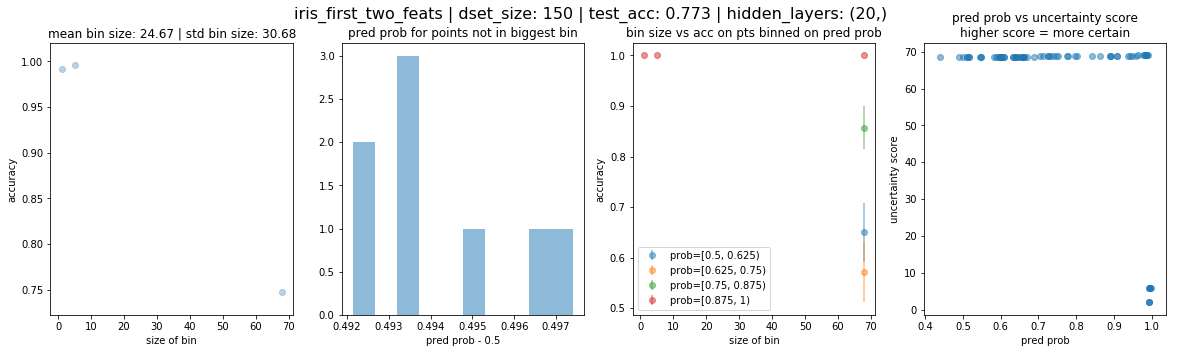

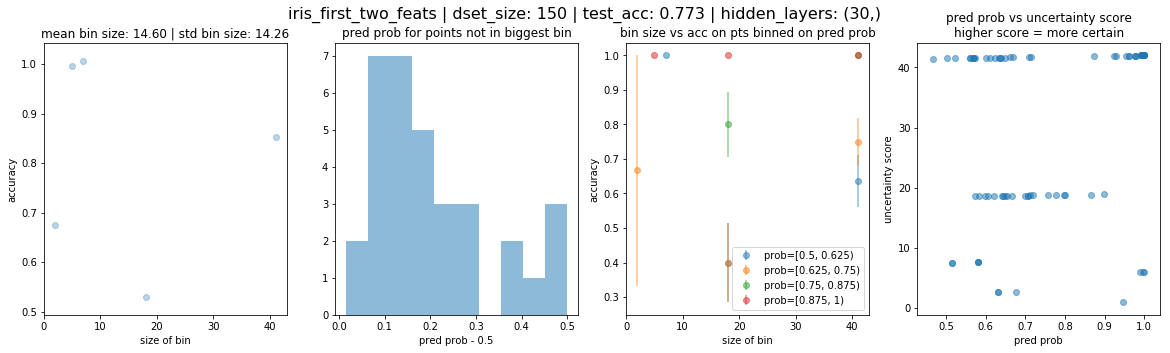

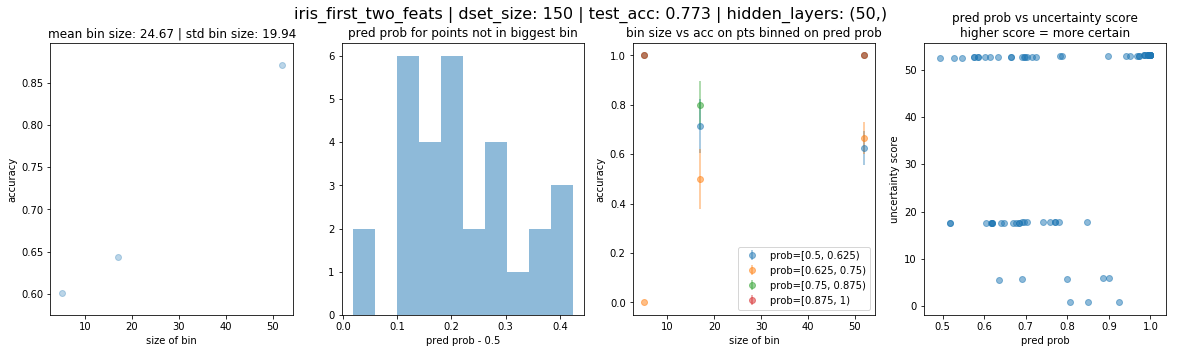

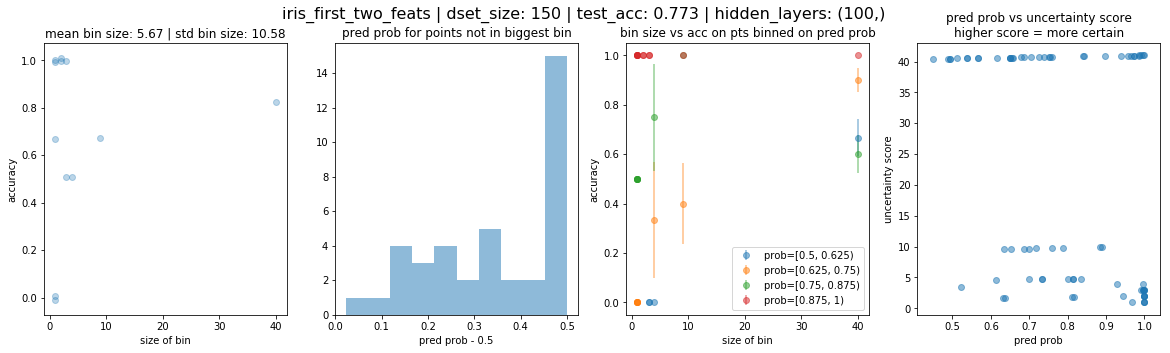

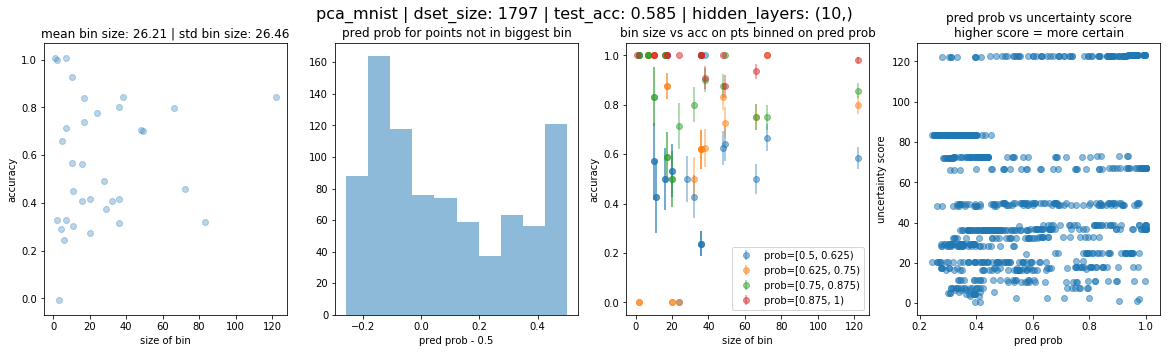

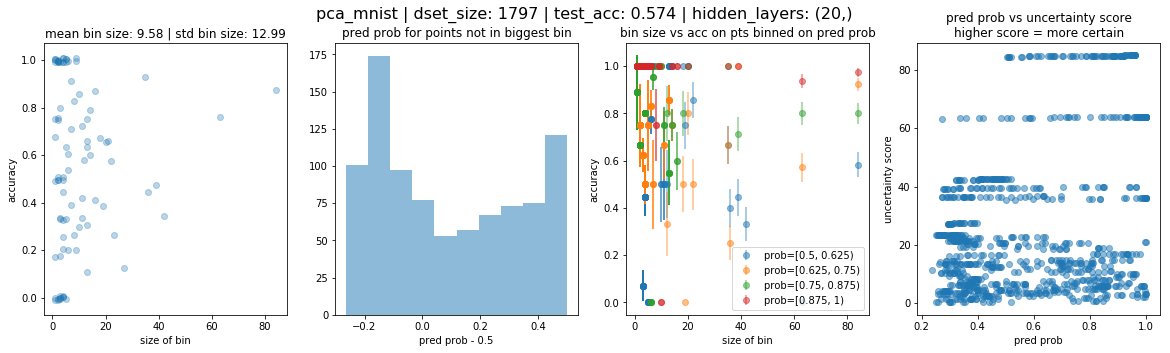

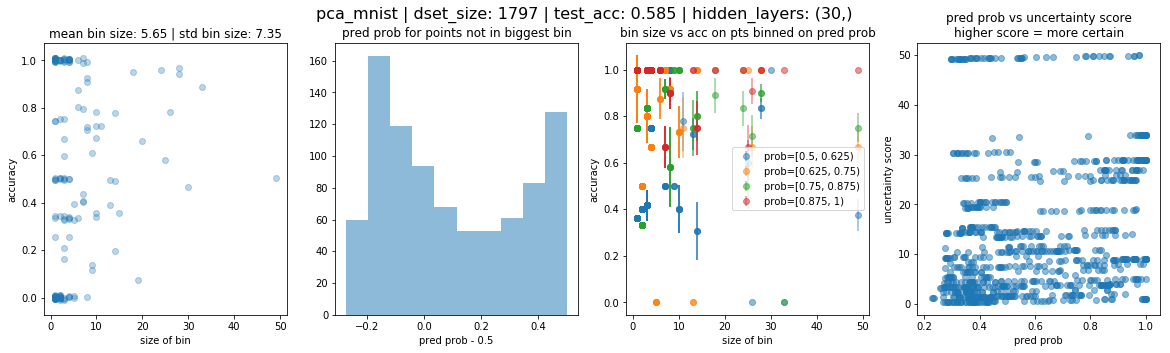

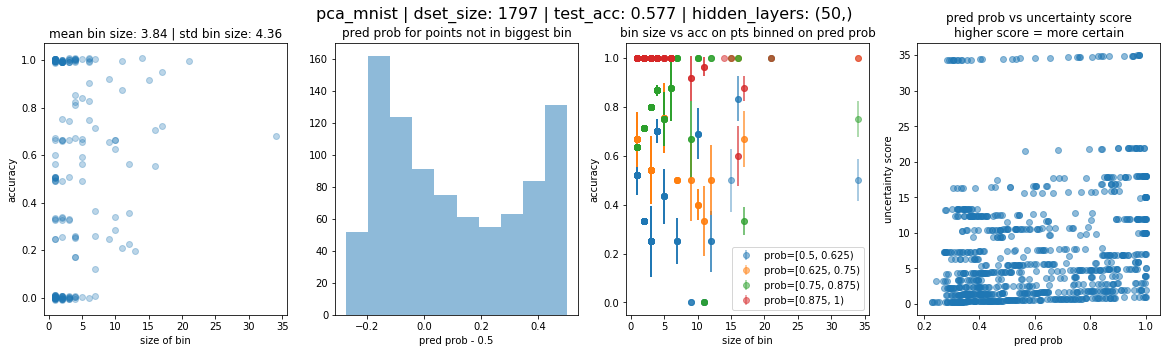

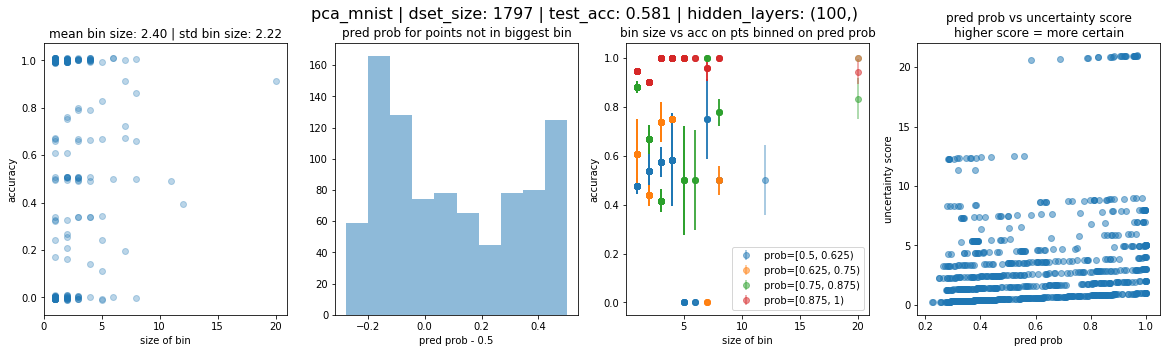

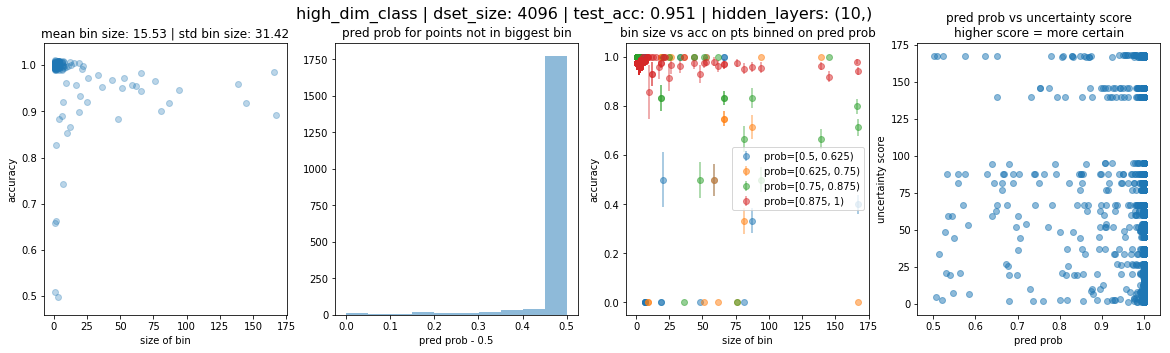

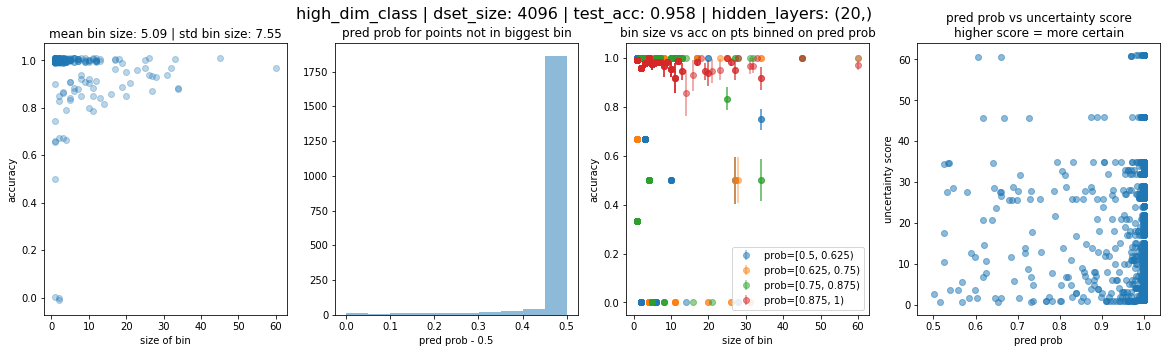

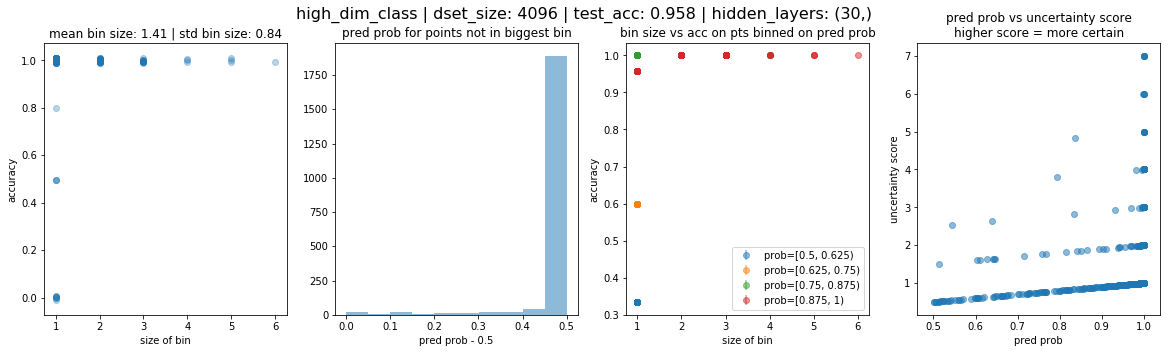

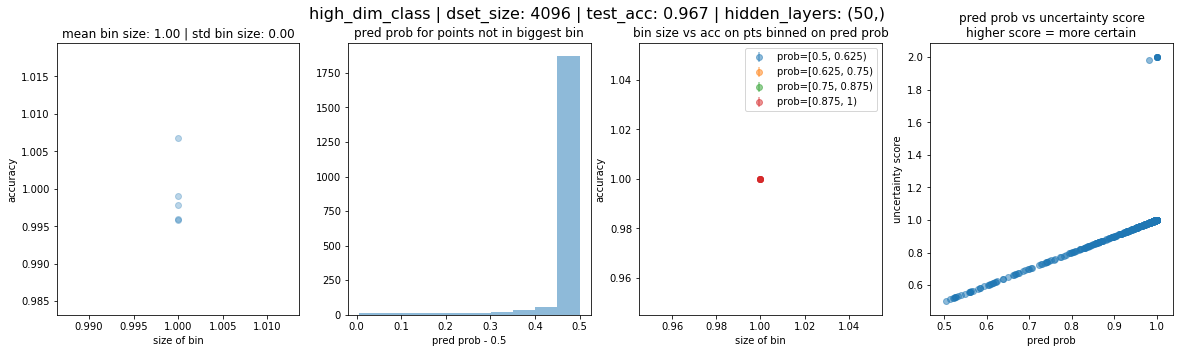

/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


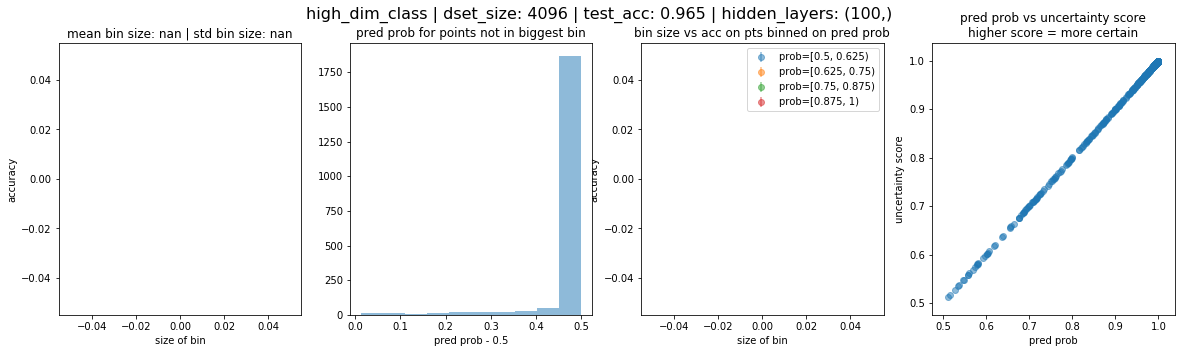

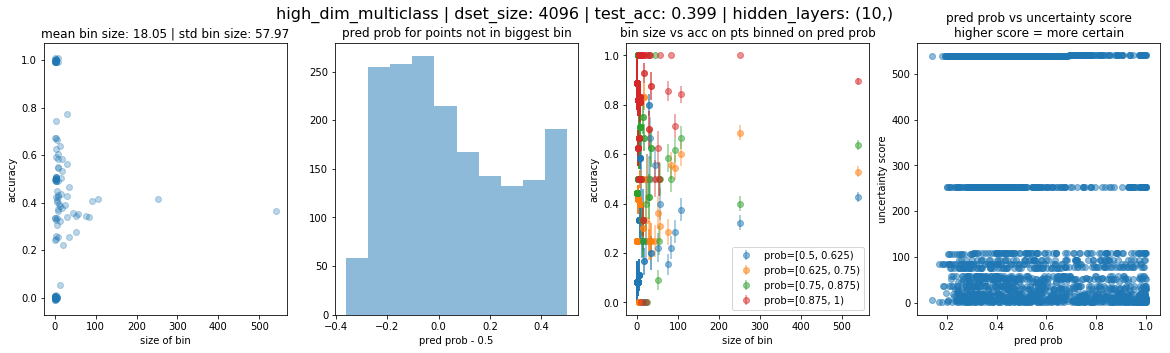

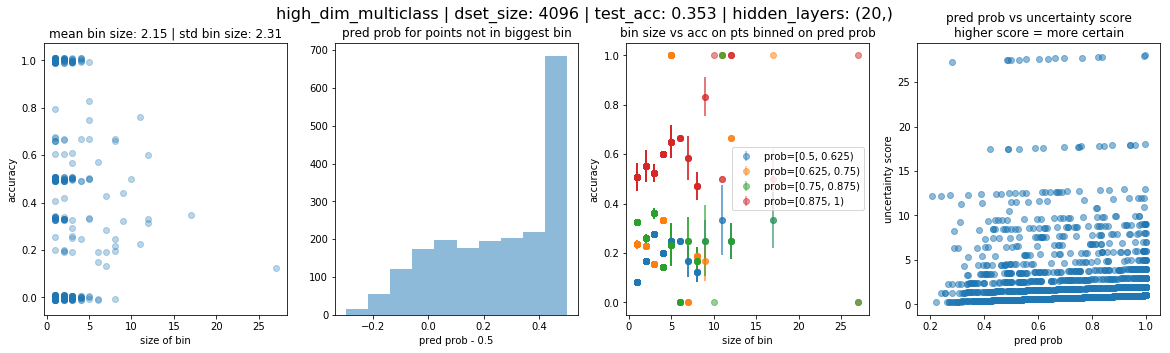

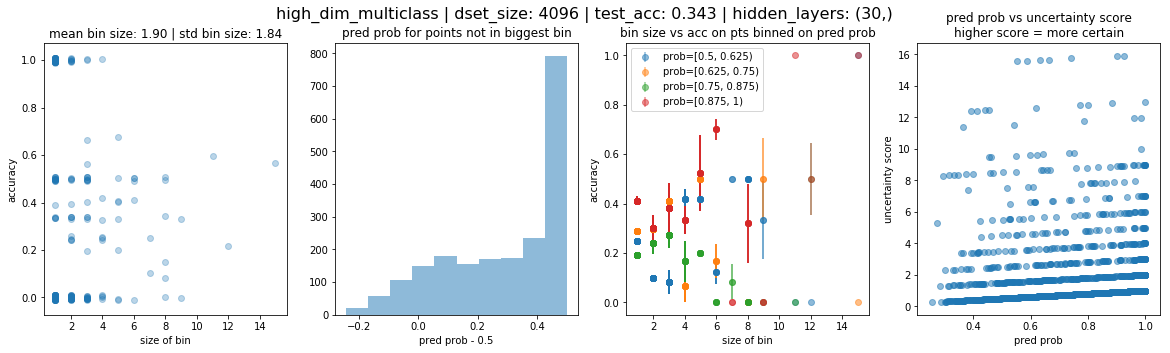

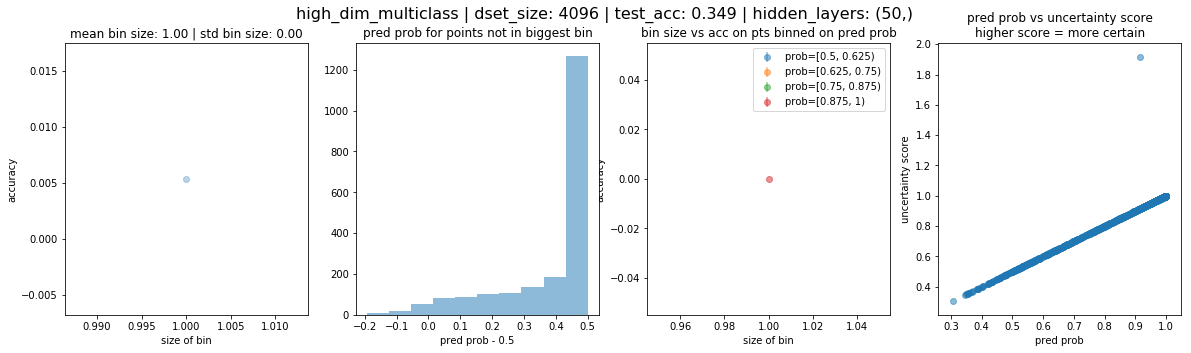

/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/aaysus/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


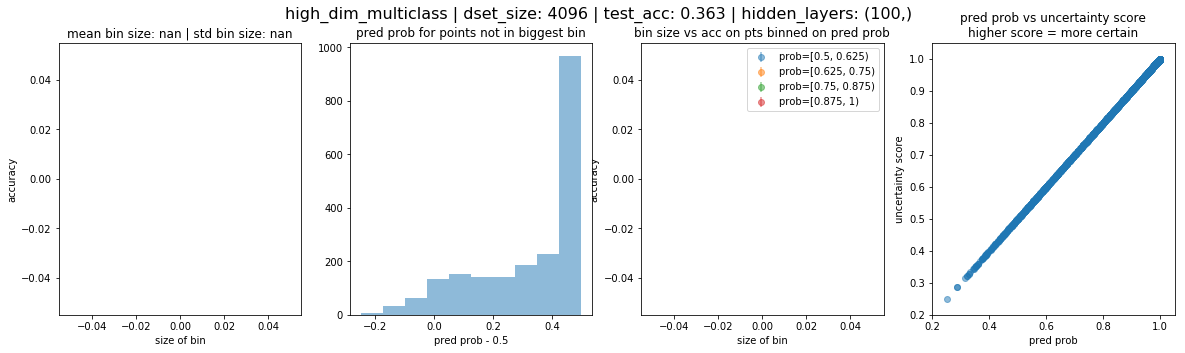

In [63]:
def activation_analysis(ds, name, num_neurons=50, num_hidden_layers=1, thresholds=[0.5, 0.625, 0.75, 0.875, 1]):
    X, y = ds
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.5)
    hidden_layers = tuple(num_neurons for _ in range(num_hidden_layers))
    clf = MLPClassifier(hidden_layer_sizes=hidden_layers, max_iter=2000)
    clf.fit(X_train, y_train)
    
    bin_numbers = get_bin_numbers(clf, X_train, num_hidden_layers)
    test_bin_numbers = get_bin_numbers(clf, X_test, num_hidden_layers)
    correct_preds = clf.predict(X_test) == y_test
    
    f = plt.figure(figsize=(20, 5))
    ax1 = f.add_subplot(141)
    # find accuracy of each activation string bin
    bin_counts = Counter(bin_numbers)
    bin_sizes, acc, bin_map = [], [], []
    for bin_num, bin_size in bin_counts.items():
        idxs = test_bin_numbers == bin_num
        if idxs.any():
            # find accuracy of points in bin
            acc.append(sum(correct_preds[idxs]) / len(correct_preds[idxs]))
            bin_sizes.append(bin_size)
            # bin pred prob of points in bin, bin those pred prods, and find acc of new bins
            bin_pred_probs = np.max(clf.predict_proba(X_test[idxs]), axis=1)
            percentiles, bin_acc = utils.get_binned_acc(bin_pred_probs, X_test[idxs], y_test[idxs], clf, thresholds=thresholds)
            error = np.sqrt(bin_acc * np.subtract(1, bin_acc) / bin_size) 
            for i, perc in enumerate(percentiles):
                bin_map.append({'bin_size': bin_size, 'threshold': perc, 'acc': bin_acc[i], 'error': error[i]})

    ax1.scatter(bin_sizes, acc + np.random.uniform(-0.01, 0.01, len(acc)), alpha=0.3)
    ax1.set_title(f"\nmean bin size: {np.mean(bin_sizes):.2f} | std bin size: {np.std(bin_sizes):.2f}")
    ax1.set_xlabel('size of bin')
    ax1.set_ylabel('accuracy')
    
    ax3 = f.add_subplot(143)
    # plot bin size vs accuracy on points binned on pred prob
    for i, thresh in enumerate(thresholds[1:]):
        thresh_accs, thresh_bin_sizes, thresh_err = [], [], []
        for bin_size in bin_sizes:
            _acc = [x['acc'] for x in bin_map if x['bin_size'] == bin_size and x['threshold'] == thresh]
            _error = [x['error'] for x in bin_map if x['bin_size'] == bin_size and x['threshold'] == thresh]
            if _acc:
                thresh_accs.append(np.average(_acc))
                thresh_bin_sizes.append(bin_size)
                thresh_err.append(np.average(_error))
        ax3.errorbar(thresh_bin_sizes, thresh_accs, yerr=thresh_err, fmt="o", alpha=0.5, label=f"prob=[{thresholds[i]}, {thresholds[i+1]})")

    ax3.set_title(f"bin size vs acc on pts binned on pred prob")
    ax3.set_xlabel('size of bin')
    ax3.set_ylabel('accuracy')
    ax3.legend()
    
    ax2 = f.add_subplot(142)
    # find predicted probablity of points that are not in biggest bin
    dist = []
    biggest_bin = list(bin_counts.keys())[0]
    for i, x in enumerate(X_test):
        in_biggest_bin = test_bin_numbers[i] == biggest_bin
        if not in_biggest_bin:
            pred = max(clf.predict_proba([x]).flatten())
            dist.append(pred - 0.5)       
    utils.plot_hist(ax2, dist, None, 'pred prob for points not in biggest bin', alpha=0.5, xlabel='pred prob - 0.5')
        
    def normalize(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    # uncertainty score vs pred prob: uncertainty score is where smallest bin size -> most uncertain, and then sort by pred prob
    # ? suggested score = 2 ^ (- bin_size + pred_prob - 0.5)
    # current score = bin_size + pred_prob
    # bin size = 0, pred prob = 0.5 --> most uncertain --> score = 0.5
    # bin size = 9, prob prob = 0.99 --> more certain --> score = 9.99

    ax4 = f.add_subplot(144)
    test_pred_probs = np.max(clf.predict_proba(X_test), axis=1)
    scores = np.array([bin_counts[test_bin_num] + test_pred_prob for test_pred_prob, test_bin_num in zip(test_pred_probs, test_bin_numbers)])

#     scores = np.exp2(np.negative(scores) / np.mean(bin_sizes))
    ax4.scatter(test_pred_probs, scores, alpha=0.5)
    ax4.set_title(f"pred prob vs uncertainty score\nhigher score = more certain")
    ax4.set_ylabel('uncertainty score')
    ax4.set_xlabel('pred prob')
    f.suptitle(f"{name} | dset_size: {len(X)} | test_acc: {clf.score(X_test, y_test):.3f} | hidden_layers: {hidden_layers}", fontsize=16)
    plt.savefig(os.path.join(logdir, f"{name}-{num_neurons}N-{num_hidden_layers}HL-embeddings"))
    plt.show()
    


for ds, name in zip(datasets, names):
#     if name != 'sonar':
#         continue
    thresholds = [0.5, 0.625, 0.75, 0.875, 1]
    # thresholds = [0.5, 0.75, 1]

    activation_analysis(ds, name, 10, 1, thresholds)
    activation_analysis(ds, name, 20, 1, thresholds)
    activation_analysis(ds, name, 30, 1, thresholds)
    activation_analysis(ds, name, 50, 1, thresholds)
    activation_analysis(ds, name, 100, 1, thresholds)
#     activation_analysis(ds, name, 200, 1)
#     activation_analysis(ds, name, 500, 1)
#     activation_analysis(ds, name, 1000, 1)

    
#     activation_analysis(ds, name, 50, 2)